In [1]:
pip install tableone

In [2]:
import os

from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tableone import TableOne


# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

auth.authenticate_user()

In [3]:
df = pd.read_csv('HFNC_latest.csv')
df.head()

stay_id  age   race gender FiO2  o2_flow FiO2_6hr FiO2_12hr  SpO2_6hr  \
0  39469161   20  WHITE      M  NaN      5.0      NaN       NaN      97.0   
1  33580370   32  WHITE      F  NaN     30.0      NaN       NaN      95.0   
2  38975964   26  OTHER      M   60      4.0      NaN       NaN      92.0   
3  34691729   28  WHITE      F  NaN     20.0      NaN       NaN     100.0   
4  36158255   29  OTHER      M  NaN     10.0      NaN       NaN      98.0   

   SpO2_12hr  ...  hemoglobin_min  hemoglobin_max  temperature_min  \
0       93.0  ...             NaN             NaN            36.67   
1       95.0  ...             NaN             NaN            36.83   
2       94.0  ...             NaN             NaN            37.06   
3       98.0  ...             NaN             NaN            36.50   
4       96.0  ...             NaN             NaN            37.33   

   temperature_max  heart_rate_max  resp_rate_min  resp_rate_max  urineoutput  \
0            37.67           112.0           12.0           27.0        300.0   
1            37.78           144.0           20.0           34.0        350.0   
2            37.56           145.0           13.0           49.0        125.0   
3            37.28           119.0           16.0           67.0        110.0   
4            38.39            78.0           12.0           24.0        220.0   

   height  weight  
0   191.0   120.6  
1     NaN     NaN  
2   150.0     NaN  
3     NaN   112.6  
4   173.0    66.8  

[5 rows x 33 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stay_id          1408 non-null   int64  
 1   age              1408 non-null   int64  
 2   race             1408 non-null   object 
 3   gender           1408 non-null   object 
 4   FiO2             667 non-null    object 
 5   o2_flow          1372 non-null   float64
 6   FiO2_6hr         63 non-null     object 
 7   FiO2_12hr        63 non-null     object 
 8   SpO2_6hr         1398 non-null   float64
 9   SpO2_12hr        1382 non-null   float64
 10  resp_6hr         1396 non-null   float64
 11  resp_12hr        1381 non-null   float64
 12  label            329 non-null    float64
 13  so2_min          397 non-null    float64
 14  so2_max          397 non-null    float64
 15  po2_min          1129 non-null   float64
 16  po2_max          1129 non-null   float64
 17  pco2_min      

In [5]:
df['FiO2'] = pd.to_numeric(df['FiO2'], errors='coerce')
df['FiO2_6hr'] = pd.to_numeric(df['FiO2_6hr'], errors='coerce')
df['FiO2_12hr'] = pd.to_numeric(df['FiO2_12hr'], errors='coerce')
df['label'] = df['label'].fillna(0)

In [6]:
#label = 1 means HFNC failure
columns = ['age', 'race', 'gender','o2_flow','FiO2','FiO2_6hr', 'FiO2_12hr','SpO2_6hr','SpO2_12hr','resp_6hr','resp_12hr','label','so2_min','so2_max','po2_min','po2_max','pco2_min','pco2_max','fio2_min','fio2_max','ph_min','ph_max','hemoglobin_min','hemoglobin_max','temperature_min','temperature_max','heart_rate_max','resp_rate_min','resp_rate_max','urineoutput','height','weight']
categorical = ['gender','race']
groupby = 'label'
table1 = TableOne(df, groupby = groupby, columns = columns, categorical = categorical, pval = True)
display(table1)

Grouped by label                                                     
                                             Missing        Overall            0.0            1.0 P-Value
n                                                              1408           1079            329        
age, mean (SD)                                     0    66.3 (14.9)    65.1 (14.7)    70.3 (14.6)  <0.001
race, n (%)                ASIAN                   0       25 (1.8)       16 (1.5)        9 (2.7)   0.011
                           BLACK                          109 (7.7)       97 (9.0)       12 (3.6)        
                           HISPANIC                        41 (2.9)       31 (2.9)       10 (3.0)        
                           OTHER                         240 (17.0)     188 (17.4)      52 (15.8)        
                           WHITE                         993 (70.5)     747 (69.2)     246 (74.8)        
gender, n (%)              F                       0     583 (41.4)     432 (40.0)     151 (45.9)   0.068
                           M                             825 (58.6)     647 (60.0)     178 (54.1)        
o2_flow, mean (SD)                                36    17.2 (14.9)    17.1 (14.7)    17.4 (15.7)   0.786
FiO2, mean (SD)                                  743    62.9 (24.0)    62.2 (23.8)    64.4 (24.5)   0.298
FiO2_6hr, mean (SD)                             1346    72.7 (23.8)    70.1 (23.7)    77.0 (23.8)   0.281
FiO2_12hr, mean (SD)                            1346    72.7 (23.8)    70.1 (23.7)    77.0 (23.8)   0.281
SpO2_6hr, mean (SD)                               10     94.8 (3.7)     94.9 (3.4)     94.2 (4.5)   0.015
SpO2_12hr, mean (SD)                              26     94.9 (3.7)     95.0 (3.4)     94.4 (4.6)   0.032
resp_6hr, mean (SD)                               12     22.2 (6.3)     21.8 (6.3)     23.3 (6.3)  <0.001
resp_12hr, mean (SD)                              27     21.9 (6.3)     21.5 (6.2)     23.0 (6.5)  <0.001
so2_min, mean (SD)                              1011    84.1 (16.6)    85.7 (15.1)    78.2 (20.1)   0.002
so2_max, mean (SD)                              1011    89.6 (13.5)    90.6 (12.9)    85.8 (15.2)   0.008
po2_min, mean (SD)                               279    58.7 (26.6)    60.2 (26.1)    54.0 (27.4)   0.001
po2_max, mean (SD)                               279    95.8 (55.0)    95.8 (53.1)    95.8 (60.7)   0.992
pco2_min, mean (SD)                              279    40.3 (12.1)    40.2 (10.7)    40.6 (15.8)   0.648
pco2_max, mean (SD)                              279    46.3 (14.3)    45.8 (12.9)    47.9 (17.9)   0.064
fio2_min, mean (SD)                             1212    66.5 (23.8)    64.7 (23.7)    70.5 (23.9)   0.121
fio2_max, mean (SD)                             1212    69.7 (24.6)    68.7 (24.9)    72.2 (23.9)   0.347
ph_min, mean (SD)                                279      7.4 (0.1)      7.4 (0.1)      7.4 (0.1)   0.001
ph_max, mean (SD)                                279      7.4 (0.1)      7.4 (0.1)      7.4 (0.1)   0.038
hemoglobin_min, mean (SD)                       1317      9.7 (2.3)     10.0 (2.3)      8.9 (2.1)   0.038
hemoglobin_max, mean (SD)                       1317      9.9 (2.3)     10.2 (2.4)      9.3 (2.1)   0.084
temperature_min, mean (SD)                        28     36.6 (0.4)     36.6 (0.4)     36.5 (0.5)  <0.001
temperature_max, mean (SD)                        28     37.4 (0.7)     37.4 (0.7)     37.3 (0.6)  <0.001
heart_rate_max, mean (SD)                          0   108.6 (21.2)   107.1 (20.6)   113.6 (22.4)  <0.001
resp_rate_min, mean (SD)                           0     14.5 (3.8)     14.3 (3.7)     15.0 (3.9)   0.004
resp_rate_max, mean (SD)                           0     32.7 (7.2)     32.3 (7.3)     34.0 (6.8)  <0.001
urineoutput, mean (SD)                            22  233.1 (230.2)  236.6 (236.6)  221.1 (207.0)   0.256
height, mean (SD)                                519   169.7 (10.4)   170.1 (10.2)   168.2 (11.0)   0.026
weight, 

## Data Preprocessing

- 針對所謂 HFNC failure的病患再進一步限制為有進行插管或使用HFNC後一個月內死亡的病患，death_time超過720hr，也就是一個月的病患，死亡因素可能有很多因素並不全然是因為HFNC failure，因此這邊選擇drop掉

In [7]:
#保留copy檔，以防不時之需
df_copy = df.copy()

- Mapping categorical to numerical data (也可label encoder)

In [8]:
gender_mapping = {'F':0, 'M':1}
df['gender'] = df['gender'].map(gender_mapping)
race_mapping = {'WHITE': 0, 'BLACK': 1, 'HiSPANIC': 2, 'ASIAN': 3, 'OTHER': 4}
df['race'] = df['race'].map(race_mapping)
df.head()

stay_id  age  race  gender  FiO2  o2_flow  FiO2_6hr  FiO2_12hr  SpO2_6hr  \
0  39469161   20   0.0       1   NaN      5.0       NaN        NaN      97.0   
1  33580370   32   0.0       0   NaN     30.0       NaN        NaN      95.0   
2  38975964   26   4.0       1  60.0      4.0       NaN        NaN      92.0   
3  34691729   28   0.0       0   NaN     20.0       NaN        NaN     100.0   
4  36158255   29   4.0       1   NaN     10.0       NaN        NaN      98.0   

   SpO2_12hr  ...  hemoglobin_min  hemoglobin_max  temperature_min  \
0       93.0  ...             NaN             NaN            36.67   
1       95.0  ...             NaN             NaN            36.83   
2       94.0  ...             NaN             NaN            37.06   
3       98.0  ...             NaN             NaN            36.50   
4       96.0  ...             NaN             NaN            37.33   

   temperature_max  heart_rate_max  resp_rate_min  resp_rate_max  urineoutput  \
0            37.67           112.0           12.0           27.0        300.0   
1            37.78           144.0           20.0           34.0        350.0   
2            37.56           145.0           13.0           49.0        125.0   
3            37.28           119.0           16.0           67.0        110.0   
4            38.39            78.0           12.0           24.0        220.0   

   height  weight  
0   191.0   120.6  
1     NaN     NaN  
2   150.0     NaN  
3     NaN   112.6  
4   173.0    66.8  

[5 rows x 33 columns]

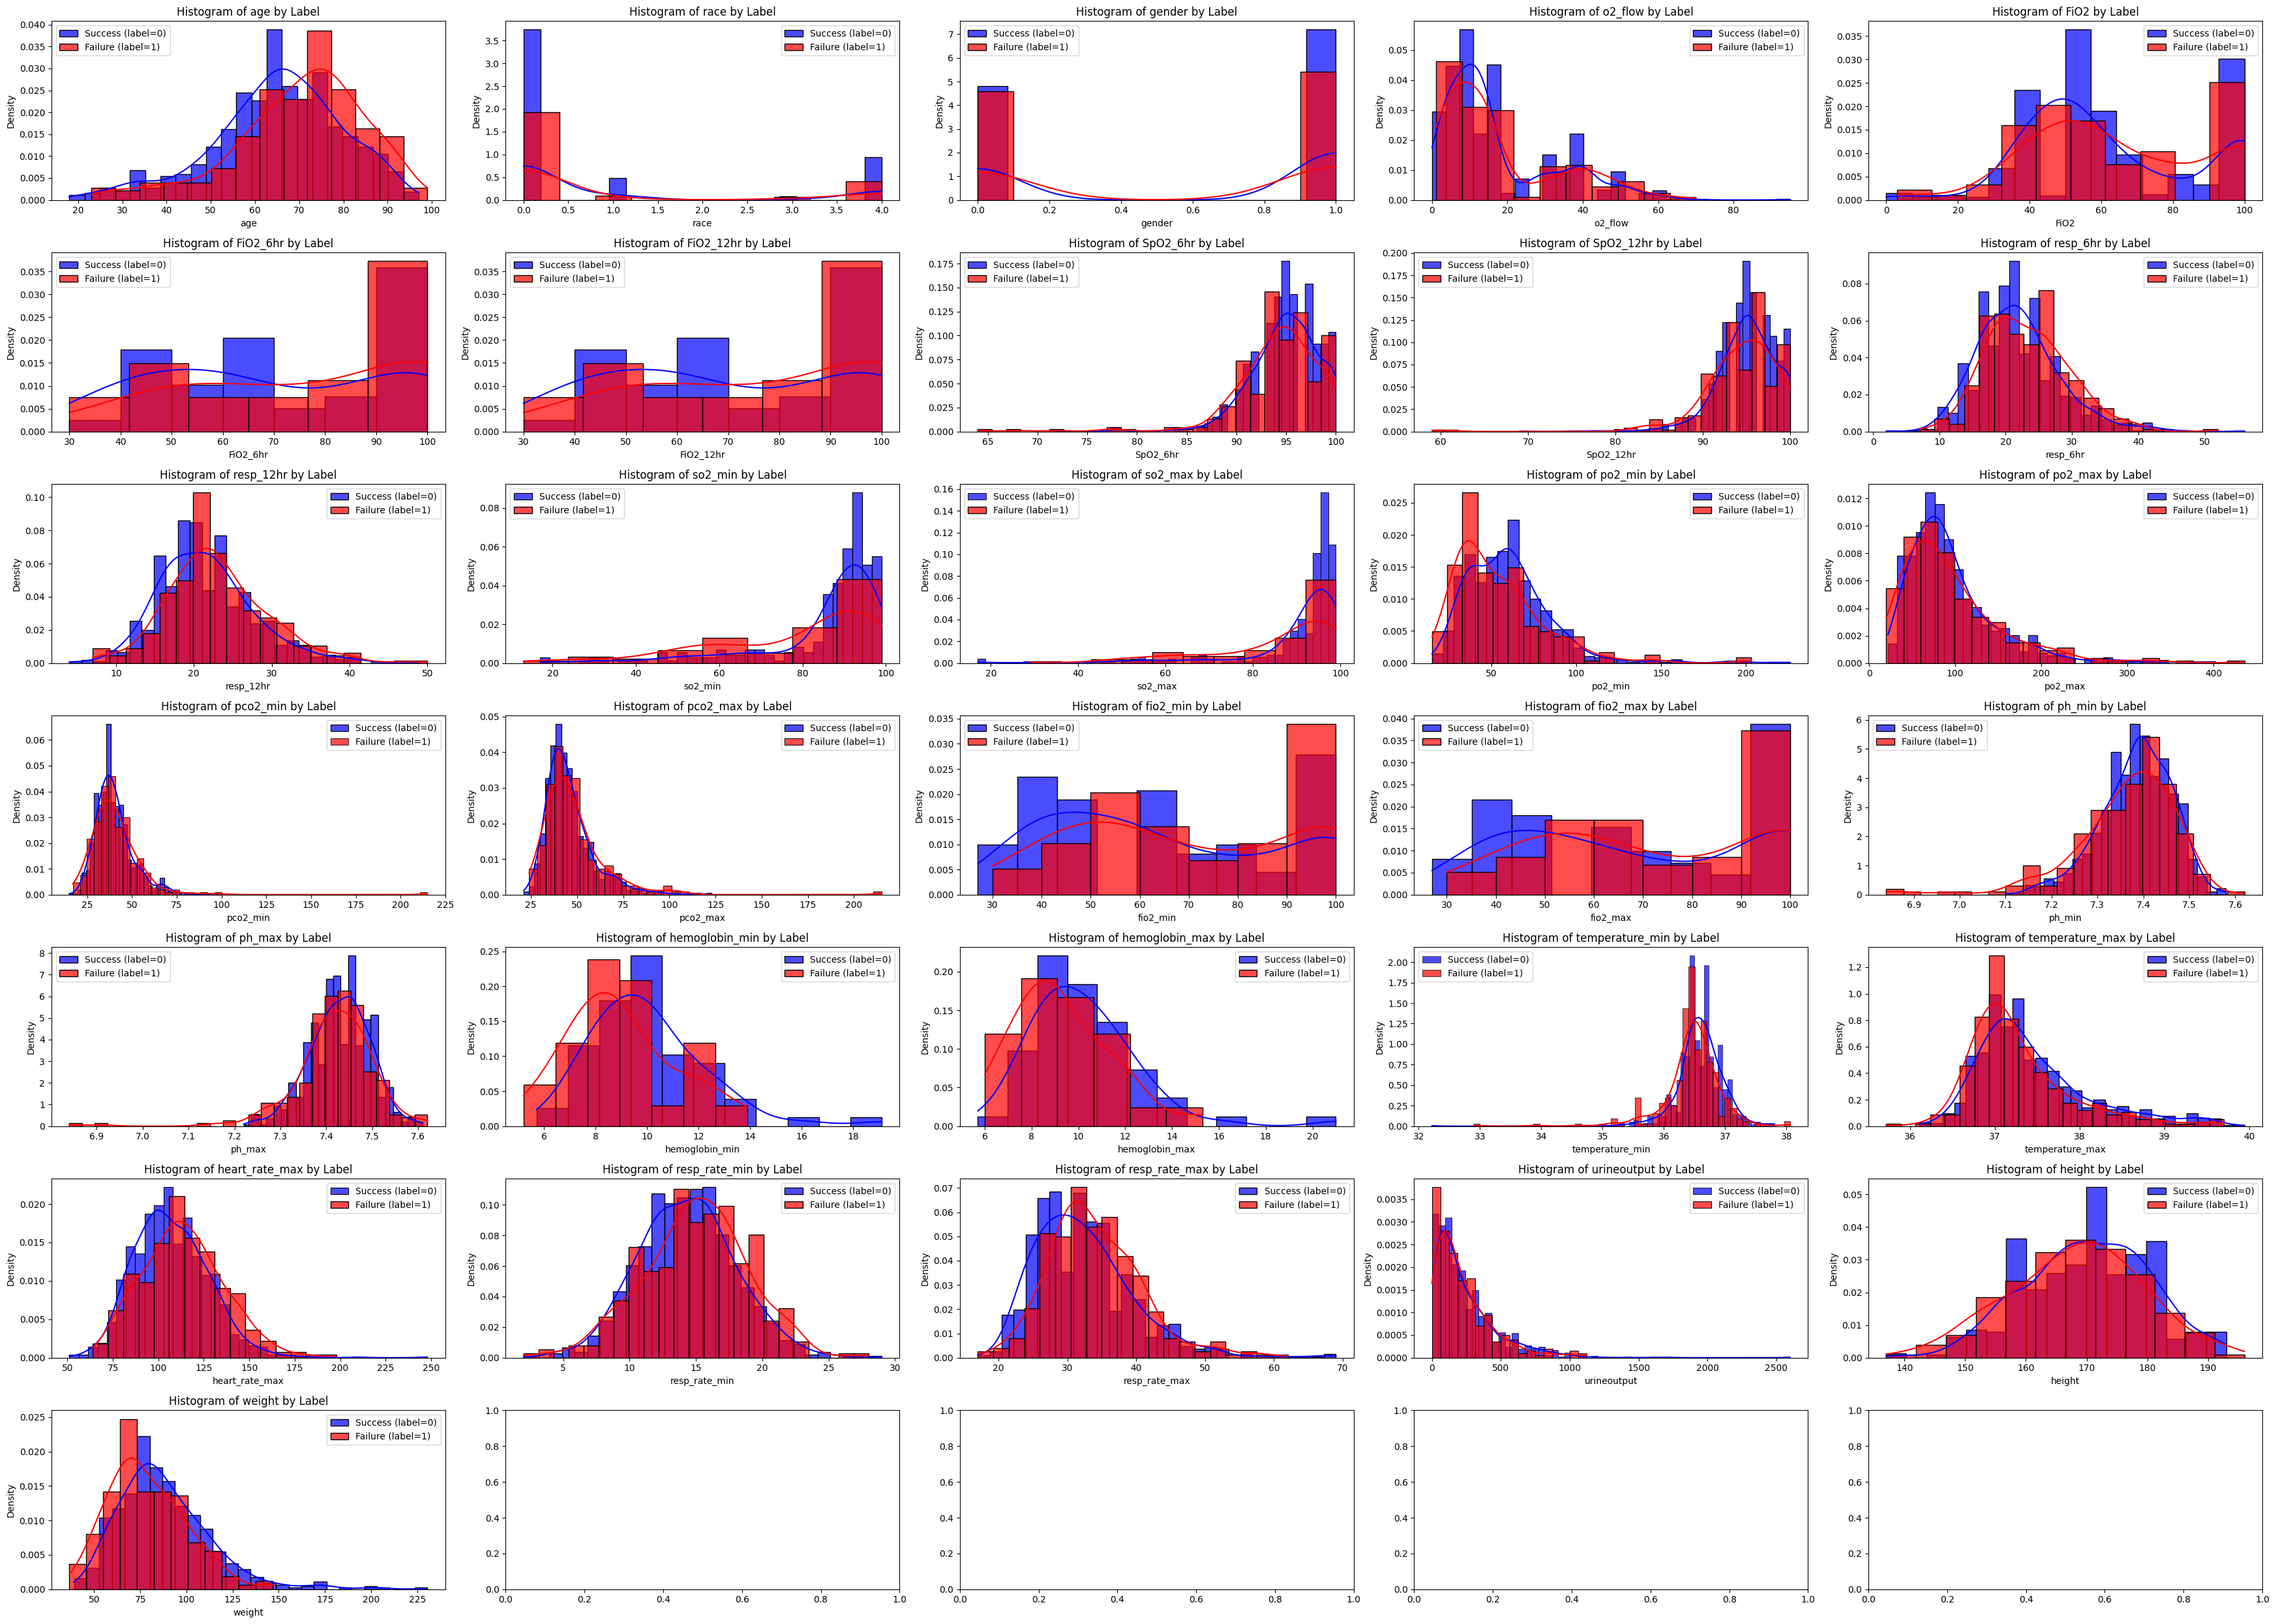

In [9]:
# 填補missing value前的distribution
#use histogram to visualize the distribution
#由於success和fail數量有所差異，y-axis = frequency不易看出feature特徵，因此改用density
columns_to_visualize = ['age', 'race', 'gender','o2_flow','FiO2','FiO2_6hr', 'FiO2_12hr','SpO2_6hr','SpO2_12hr','resp_6hr','resp_12hr','so2_min','so2_max','po2_min','po2_max','pco2_min','pco2_max','fio2_min','fio2_max','ph_min','ph_max','hemoglobin_min','hemoglobin_max','temperature_min','temperature_max','heart_rate_max','resp_rate_min','resp_rate_max','urineoutput','height','weight']

fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(35, 25))

axes = axes.flatten()

for i, column in enumerate(columns_to_visualize):
    data_success = df[df['label'] == 0][column].to_numpy()
    data_fail = df[df['label'] == 1][column].to_numpy()
    sns.histplot(data_success, color='blue', alpha=0.7, label='Success (label=0)', kde=True, ax=axes[i], stat='density', common_norm=False)
    sns.histplot(data_fail, color='red', alpha=0.7, label='Failure (label=1)', kde=True, ax=axes[i], stat='density', common_norm=False)

    axes[i].set_title(f'Histogram of {column} by Label')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.tight_layout()
plt.show()


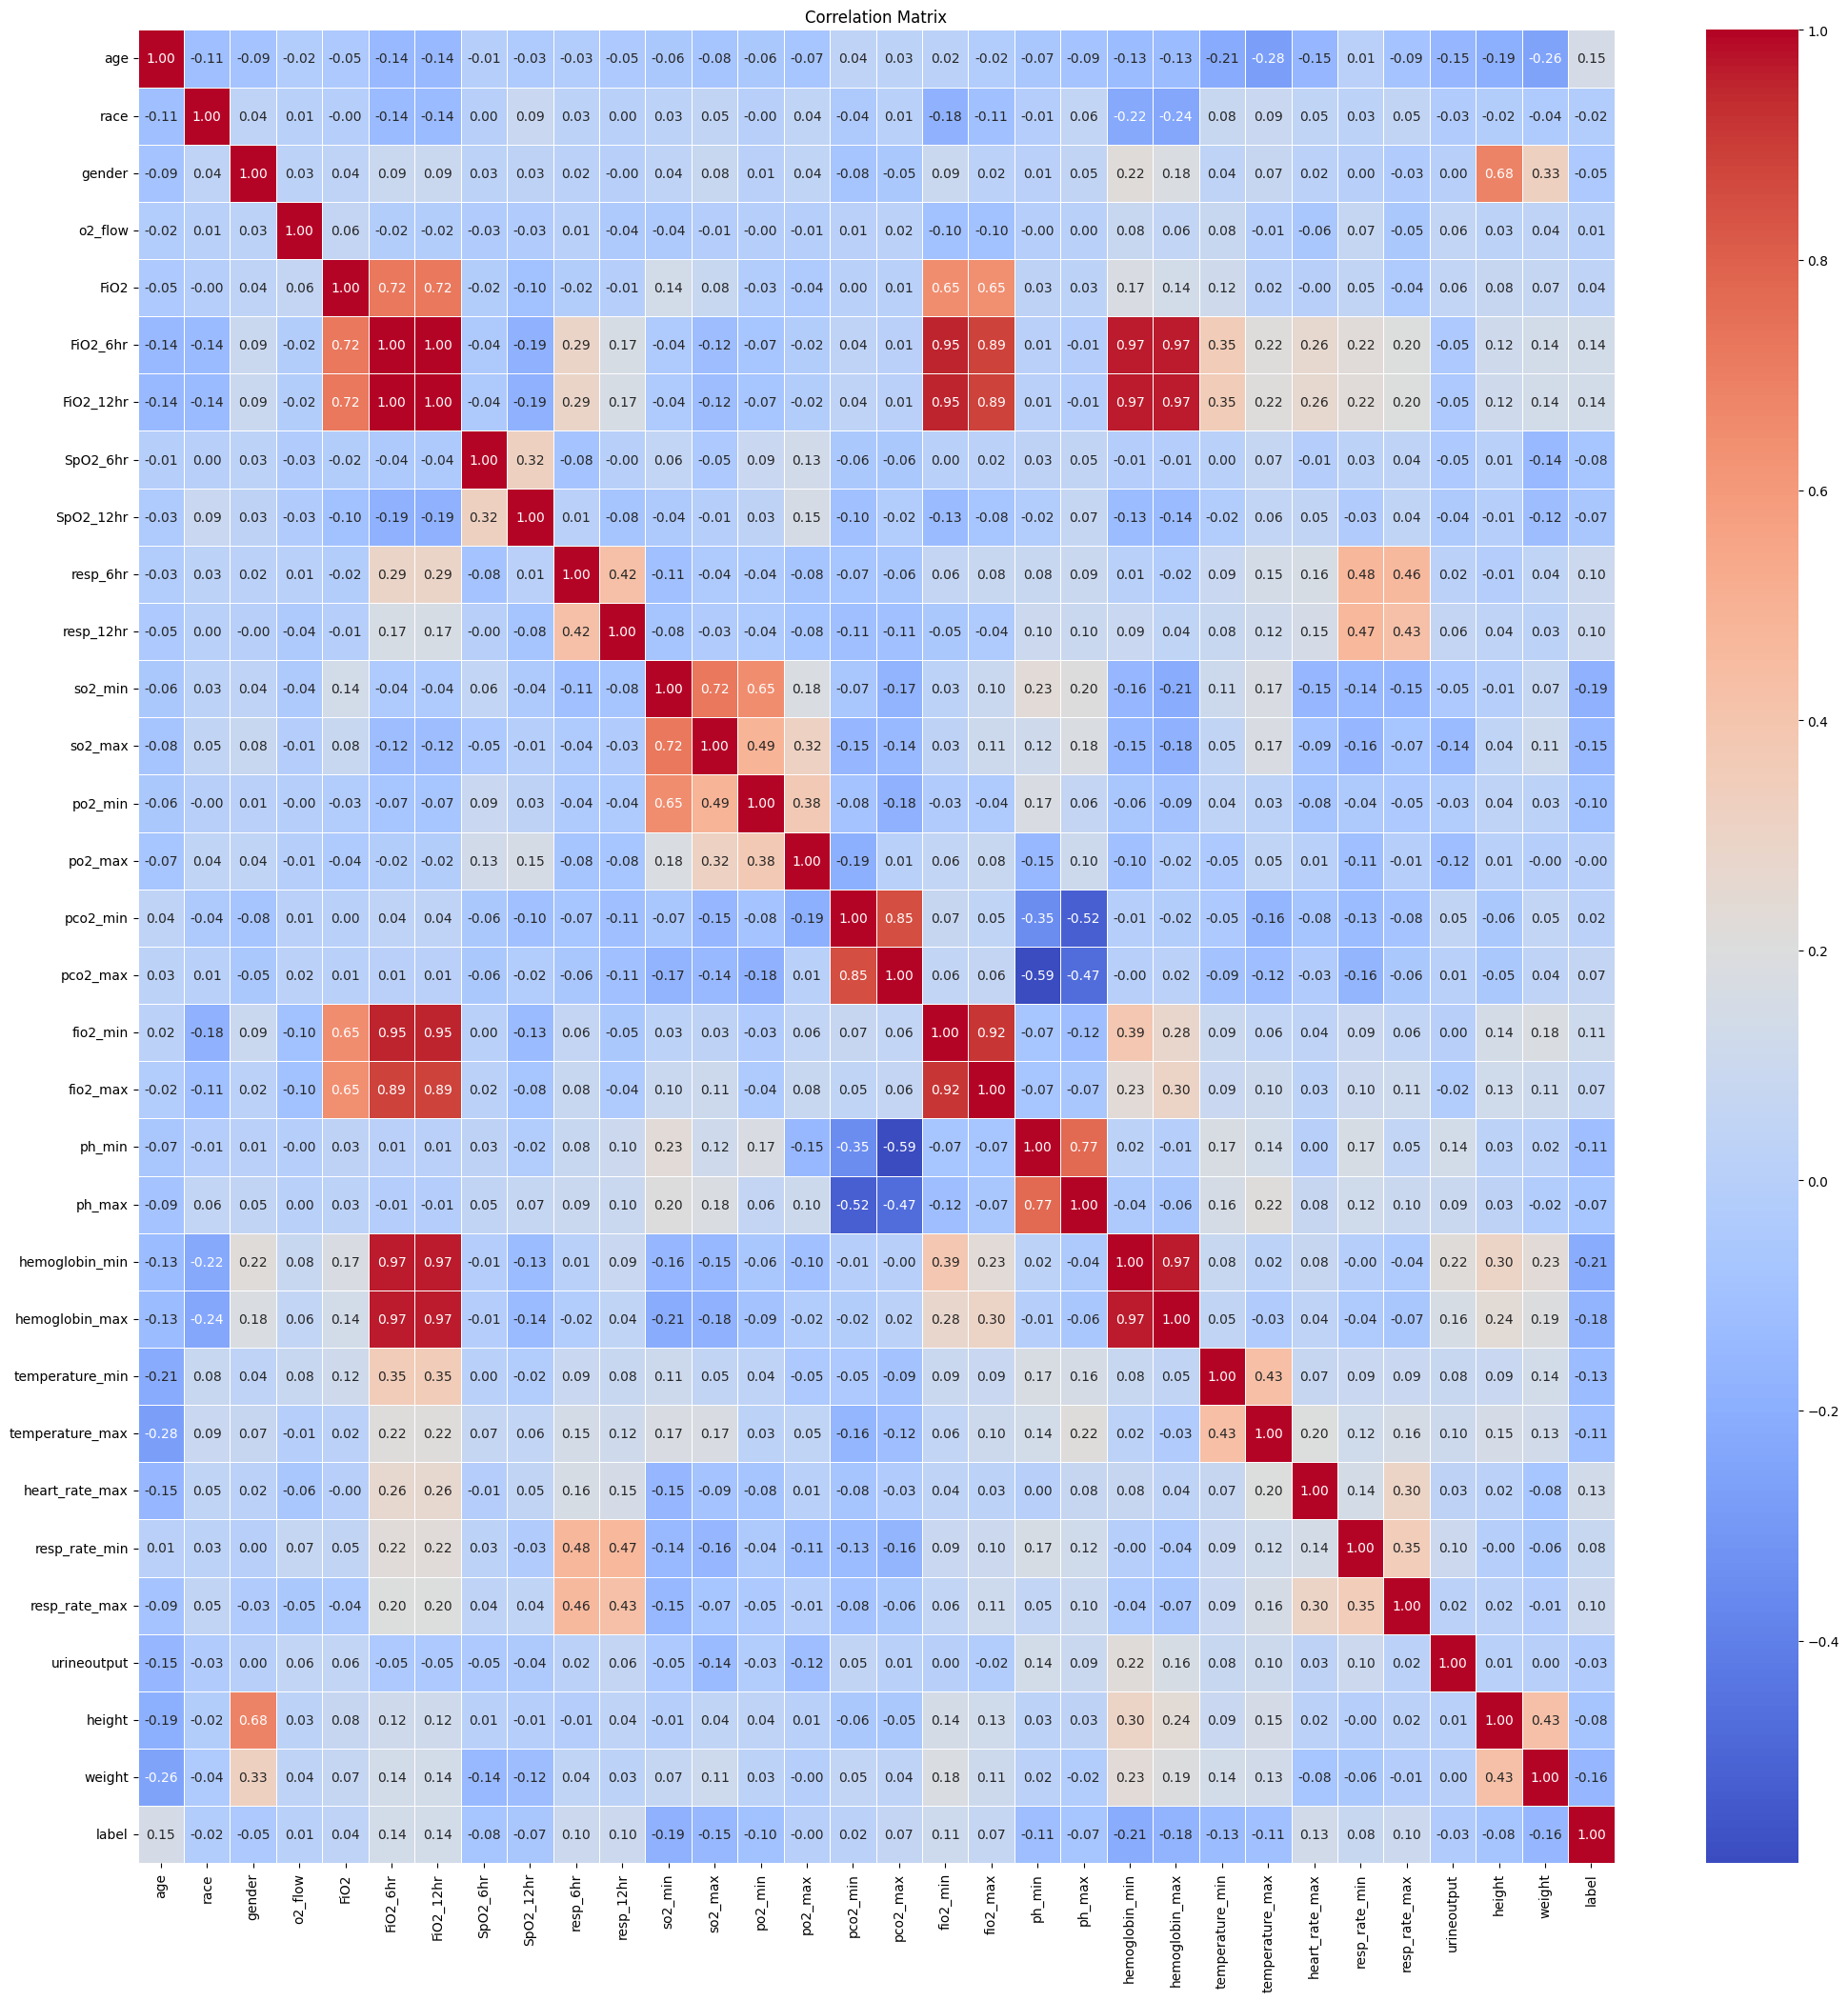

In [10]:
# Select columns for the correlation matrix
columns_for_correlation = ['age', 'race', 'gender','o2_flow','FiO2','FiO2_6hr', 'FiO2_12hr','SpO2_6hr','SpO2_12hr','resp_6hr','resp_12hr','so2_min','so2_max','po2_min','po2_max','pco2_min','pco2_max','fio2_min','fio2_max','ph_min','ph_max','hemoglobin_min','hemoglobin_max','temperature_min','temperature_max','heart_rate_max','resp_rate_min','resp_rate_max','urineoutput','height','weight','label']

# Calculate the correlation matrix
correlation_matrix = df[columns_for_correlation].corr()

# Set up the size of the plot
plt.figure(figsize=(25, 25))

annot_font_size = 10
# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": annot_font_size})

# Show the plot
plt.title('Correlation Matrix')
plt.show()

In [11]:
# 先針對FiO2_6hr, FiO2_12hr, SpO2_6hr, SpO2_12hr以及resp_6hr, resp_12hr補值，如果前面時間段有值就拿來用
# 其中FiO2會有紀錄為0的資料，估計為記錄錯誤，選擇直接drop掉
delete_index = []
column_name = ['FiO2_6hr','FiO2_12hr']
for i in column_name:
  for j in range(0,df.shape[0]):
    if pd.isna(df[i][j]):
      df[i][j] = df['FiO2'][j]

for j in range(0,df.shape[0]):
  if df['FiO2'][j] == 0:
    delete_index.append(j)

for j in range(0,df.shape[0]):
  if pd.isna(df['SpO2_12hr'][j]):
    df['SpO2_12hr'][j] = df['SpO2_6hr'][j]

for j in range(0,df.shape[0]):
  if pd.isna(df['resp_12hr'][j]):
    df['resp_12hr'][j] = df['resp_6hr'][j]

df = df.drop(delete_index)
df = df.reset_index(drop=True)
df.head()

stay_id  age  race  gender  FiO2  o2_flow  FiO2_6hr  FiO2_12hr  SpO2_6hr  \
0  39469161   20   0.0       1   NaN      5.0       NaN        NaN      97.0   
1  33580370   32   0.0       0   NaN     30.0       NaN        NaN      95.0   
2  38975964   26   4.0       1  60.0      4.0      60.0       60.0      92.0   
3  34691729   28   0.0       0   NaN     20.0       NaN        NaN     100.0   
4  36158255   29   4.0       1   NaN     10.0       NaN        NaN      98.0   

   SpO2_12hr  ...  hemoglobin_min  hemoglobin_max  temperature_min  \
0       93.0  ...             NaN             NaN            36.67   
1       95.0  ...             NaN             NaN            36.83   
2       94.0  ...             NaN             NaN            37.06   
3       98.0  ...             NaN             NaN            36.50   
4       96.0  ...             NaN             NaN            37.33   

   temperature_max  heart_rate_max  resp_rate_min  resp_rate_max  urineoutput  \
0            37.67           112.0           12.0           27.0        300.0   
1            37.78           144.0           20.0           34.0        350.0   
2            37.56           145.0           13.0           49.0        125.0   
3            37.28           119.0           16.0           67.0        110.0   
4            38.39            78.0           12.0           24.0        220.0   

   height  weight  
0   191.0   120.6  
1     NaN     NaN  
2   150.0     NaN  
3     NaN   112.6  
4   173.0    66.8  

[5 rows x 33 columns]

In [12]:
# missing value嘗試兩種填補值的方式 median 以及 KNN (不用MICE了，它好爛！！！)
df_median = df.copy()
df_knn = df.copy()

columns_name = ['age', 'race', 'gender','FiO2', 'o2_flow','FiO2_6hr', 'FiO2_12hr','SpO2_6hr','SpO2_12hr','resp_6hr','resp_12hr','so2_min','so2_max','po2_min','po2_max','pco2_min','pco2_max','fio2_min','fio2_max','ph_min','ph_max','hemoglobin_min','hemoglobin_max','temperature_min','temperature_max','heart_rate_max','resp_rate_min','resp_rate_max','urineoutput','height','weight']
#median
for i in columns_name:
  # 分割數據
  subset_0 = df_median[df_median['label'] == 0]
  subset_1 = df_median[df_median['label'] == 1]
  # 計算中位數
  median_0 = subset_0[columns_name].median()
  median_1 = subset_1[columns_name].median()
  df_median.loc[df_median['label'] == 0, columns_name] = df_median.loc[df_median['label'] == 0, columns_name].fillna(median_0)
  df_median.loc[df_median['label'] == 1, columns_name] = df_median.loc[df_median['label'] == 1, columns_name].fillna(median_1)
display(df_median.head())

#knn (n = 3)
knn_imputer = KNNImputer(n_neighbors=3, weights="uniform")
df_knn = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df.columns)
display(df_knn.head())

stay_id  age  race  gender  FiO2  o2_flow  FiO2_6hr  FiO2_12hr  SpO2_6hr  \
0  39469161   20   0.0       1  55.0      5.0      55.0       55.0      97.0   
1  33580370   32   0.0       0  55.0     30.0      55.0       55.0      95.0   
2  38975964   26   4.0       1  60.0      4.0      60.0       60.0      92.0   
3  34691729   28   0.0       0  55.0     20.0      55.0       55.0     100.0   
4  36158255   29   4.0       1  60.0     10.0      60.0       60.0      98.0   

   SpO2_12hr  ...  hemoglobin_min  hemoglobin_max  temperature_min  \
0       93.0  ...             9.7             9.9            36.67   
1       95.0  ...             9.7             9.9            36.83   
2       94.0  ...             9.7             9.9            37.06   
3       98.0  ...             9.7             9.9            36.50   
4       96.0  ...             8.5             9.1            37.33   

   temperature_max  heart_rate_max  resp_rate_min  resp_rate_max  urineoutput  \
0            37.67           112.0           12.0           27.0        300.0   
1            37.78           144.0           20.0           34.0        350.0   
2            37.56           145.0           13.0           49.0        125.0   
3            37.28           119.0           16.0           67.0        110.0   
4            38.39            78.0           12.0           24.0        220.0   

   height  weight  
0   191.0   120.6  
1   170.0    83.8  
2   150.0    83.8  
3   170.0   112.6  
4   173.0    66.8  

[5 rows x 33 columns]

stay_id   age  race  gender       FiO2  o2_flow   FiO2_6hr  FiO2_12hr  \
0  39469161.0  20.0   0.0     1.0  60.000000      5.0  60.000000  60.000000   
1  33580370.0  32.0   0.0     0.0  66.666667     30.0  73.333333  73.333333   
2  38975964.0  26.0   4.0     1.0  60.000000      4.0  60.000000  60.000000   
3  34691729.0  28.0   0.0     0.0  58.333333     20.0  58.333333  58.333333   
4  36158255.0  29.0   4.0     1.0  80.000000     10.0  86.666667  86.666667   

   SpO2_6hr  SpO2_12hr  ...  hemoglobin_min  hemoglobin_max  temperature_min  \
0      97.0       93.0  ...        8.566667        8.733333            36.67   
1      95.0       95.0  ...       10.933333       10.933333            36.83   
2      92.0       94.0  ...        8.466667        8.800000            37.06   
3     100.0       98.0  ...       10.533333       10.533333            36.50   
4      98.0       96.0  ...        8.833333        9.800000            37.33   

   temperature_max  heart_rate_max  resp_rate_min  resp_rate_max  urineoutput  \
0            37.67           112.0           12.0           27.0        300.0   
1            37.78           144.0           20.0           34.0        350.0   
2            37.56           145.0           13.0           49.0        125.0   
3            37.28           119.0           16.0           67.0        110.0   
4            38.39            78.0           12.0           24.0        220.0   

       height      weight  
0  191.000000  120.600000  
1  168.666667  104.266667  
2  150.000000   66.800000  
3  164.000000  112.600000  
4  173.000000   66.800000  

[5 rows x 33 columns]

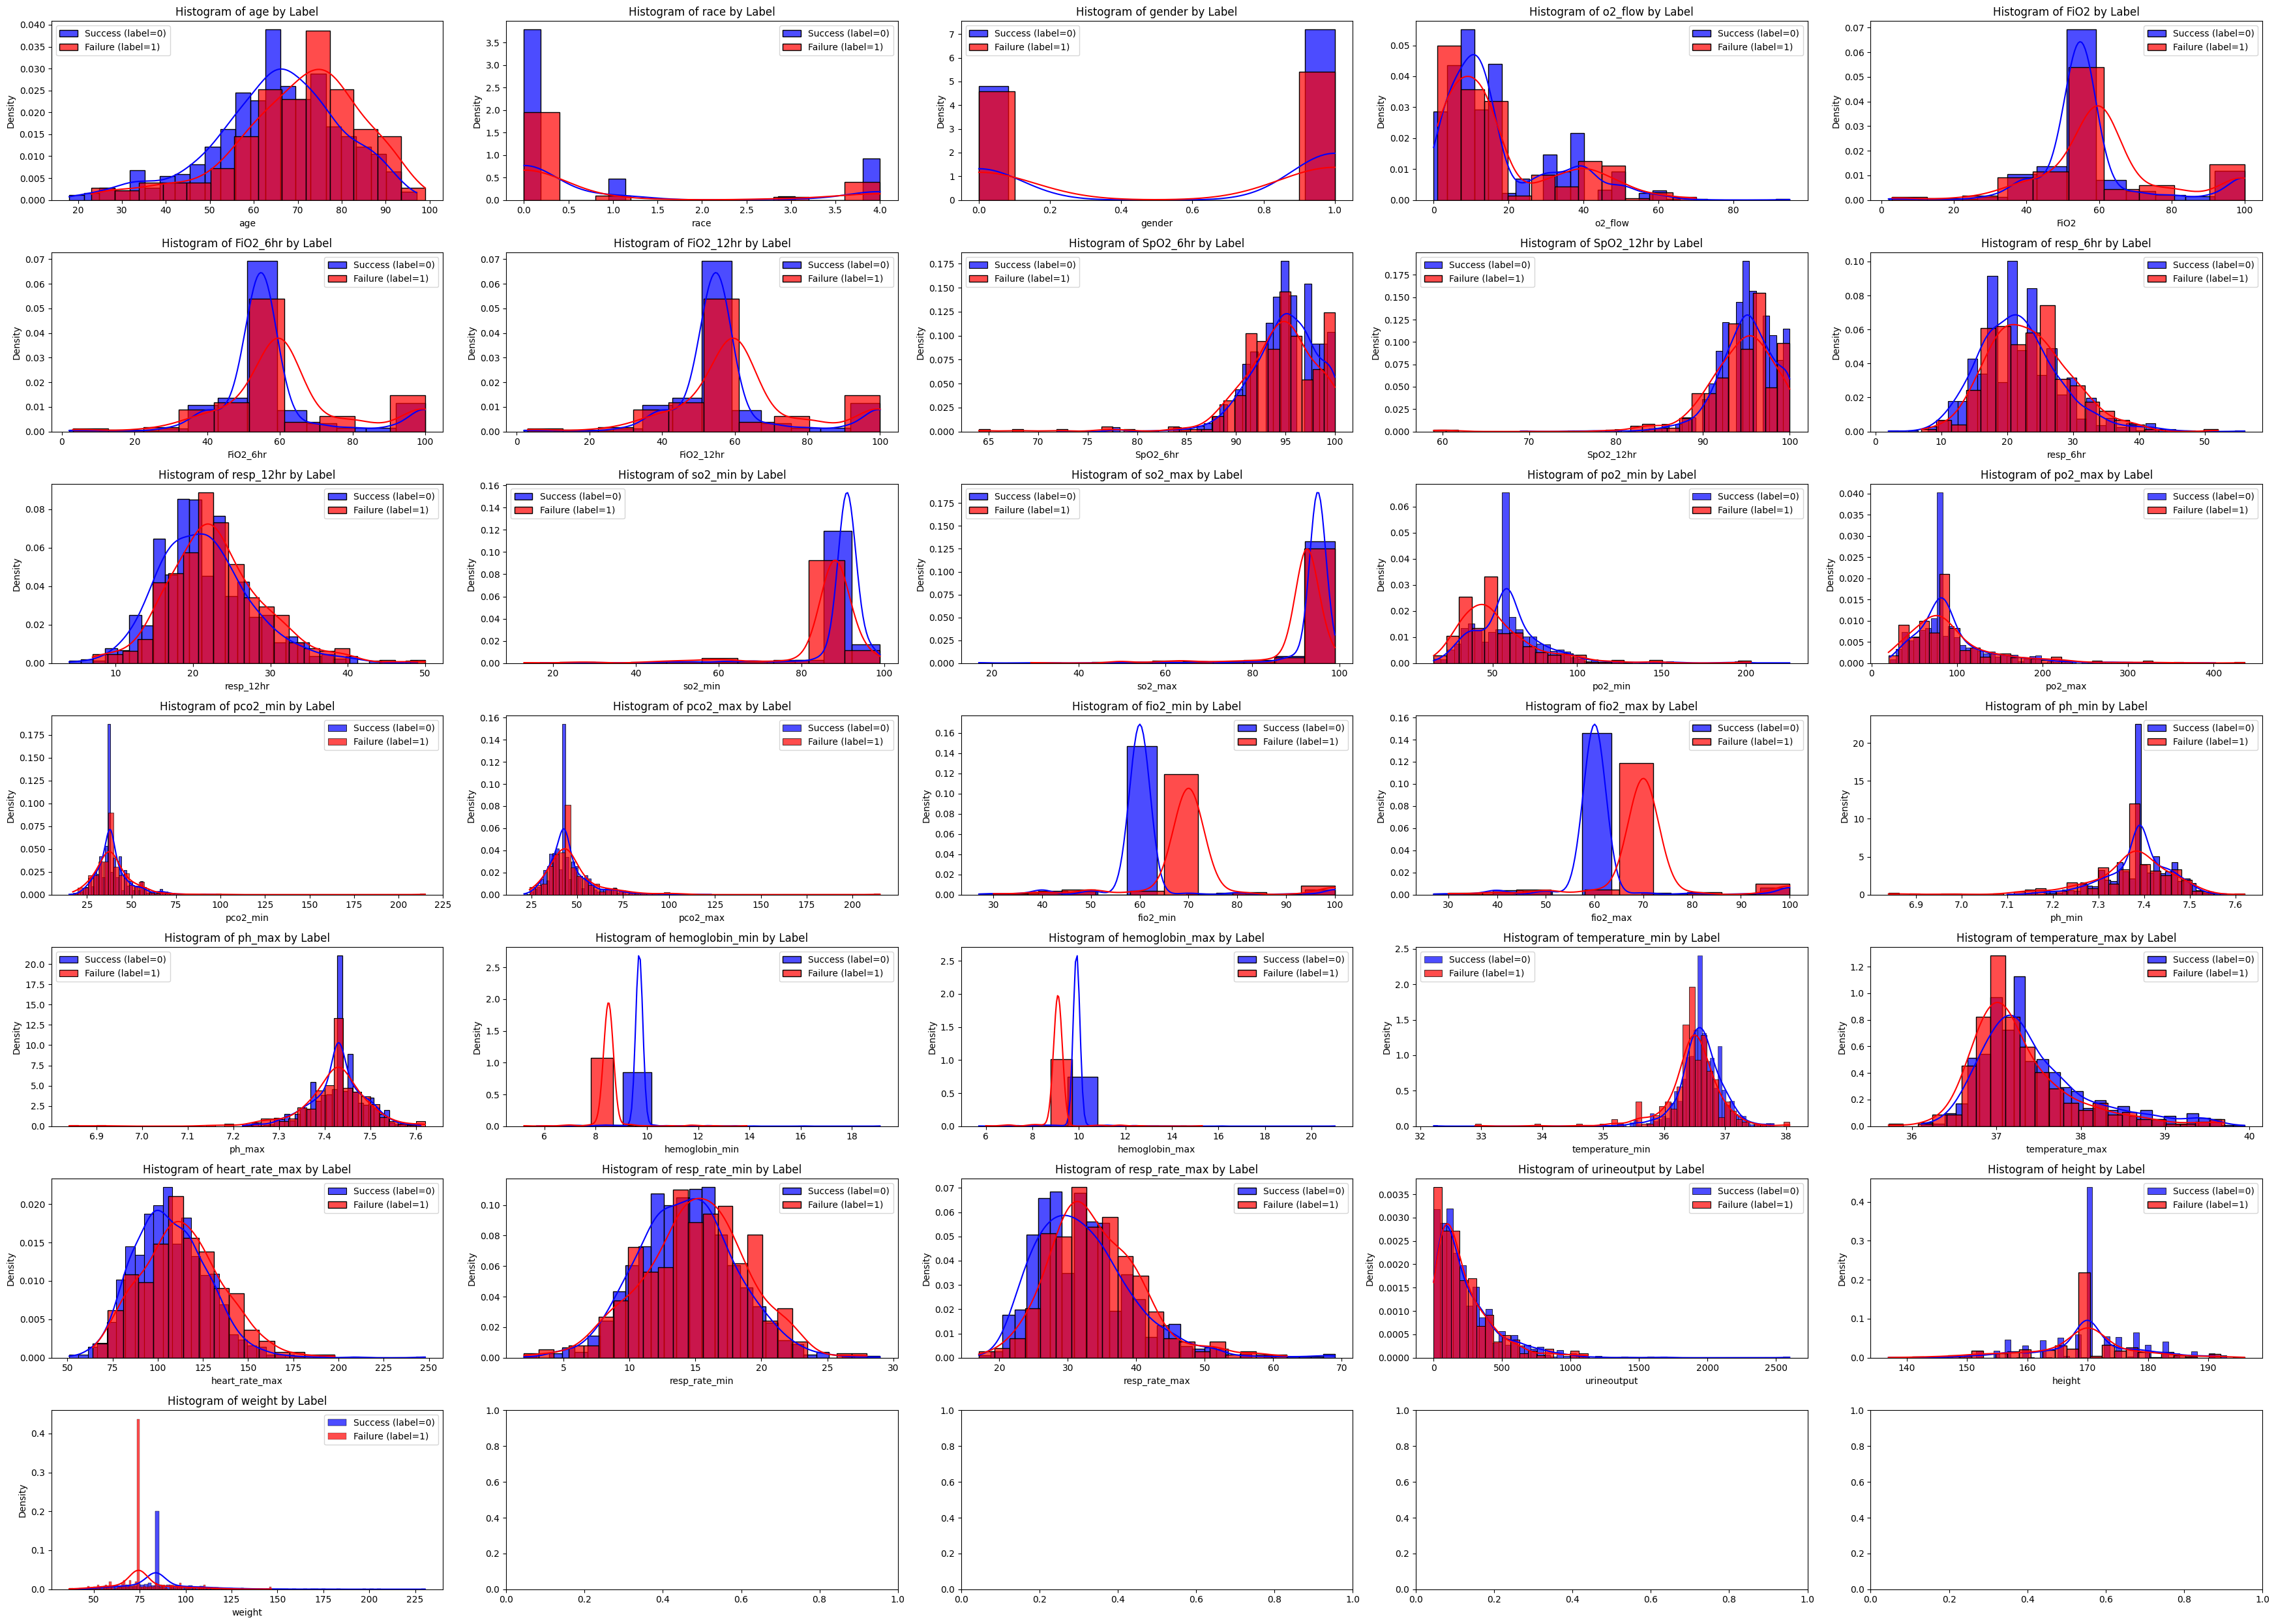

In [13]:
# observe the feature distribution after imputing missing value (median)
columns_to_visualize = ['age', 'race', 'gender','o2_flow','FiO2','FiO2_6hr', 'FiO2_12hr','SpO2_6hr','SpO2_12hr','resp_6hr','resp_12hr','so2_min','so2_max','po2_min','po2_max','pco2_min','pco2_max','fio2_min','fio2_max','ph_min','ph_max','hemoglobin_min','hemoglobin_max','temperature_min','temperature_max','heart_rate_max','resp_rate_min','resp_rate_max','urineoutput','height','weight']

fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(35, 25))

axes = axes.flatten()

for i, column in enumerate(columns_to_visualize):
    data_success = df_median[df_median['label'] == 0][column].to_numpy()
    data_fail = df_median[df_median['label'] == 1][column].to_numpy()
    sns.histplot(data_success, color='blue', alpha=0.7, label='Success (label=0)', kde=True, ax=axes[i], stat='density', common_norm=False)
    sns.histplot(data_fail, color='red', alpha=0.7, label='Failure (label=1)', kde=True, ax=axes[i], stat='density', common_norm=False)

    axes[i].set_title(f'Histogram of {column} by Label')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.tight_layout()
plt.show()


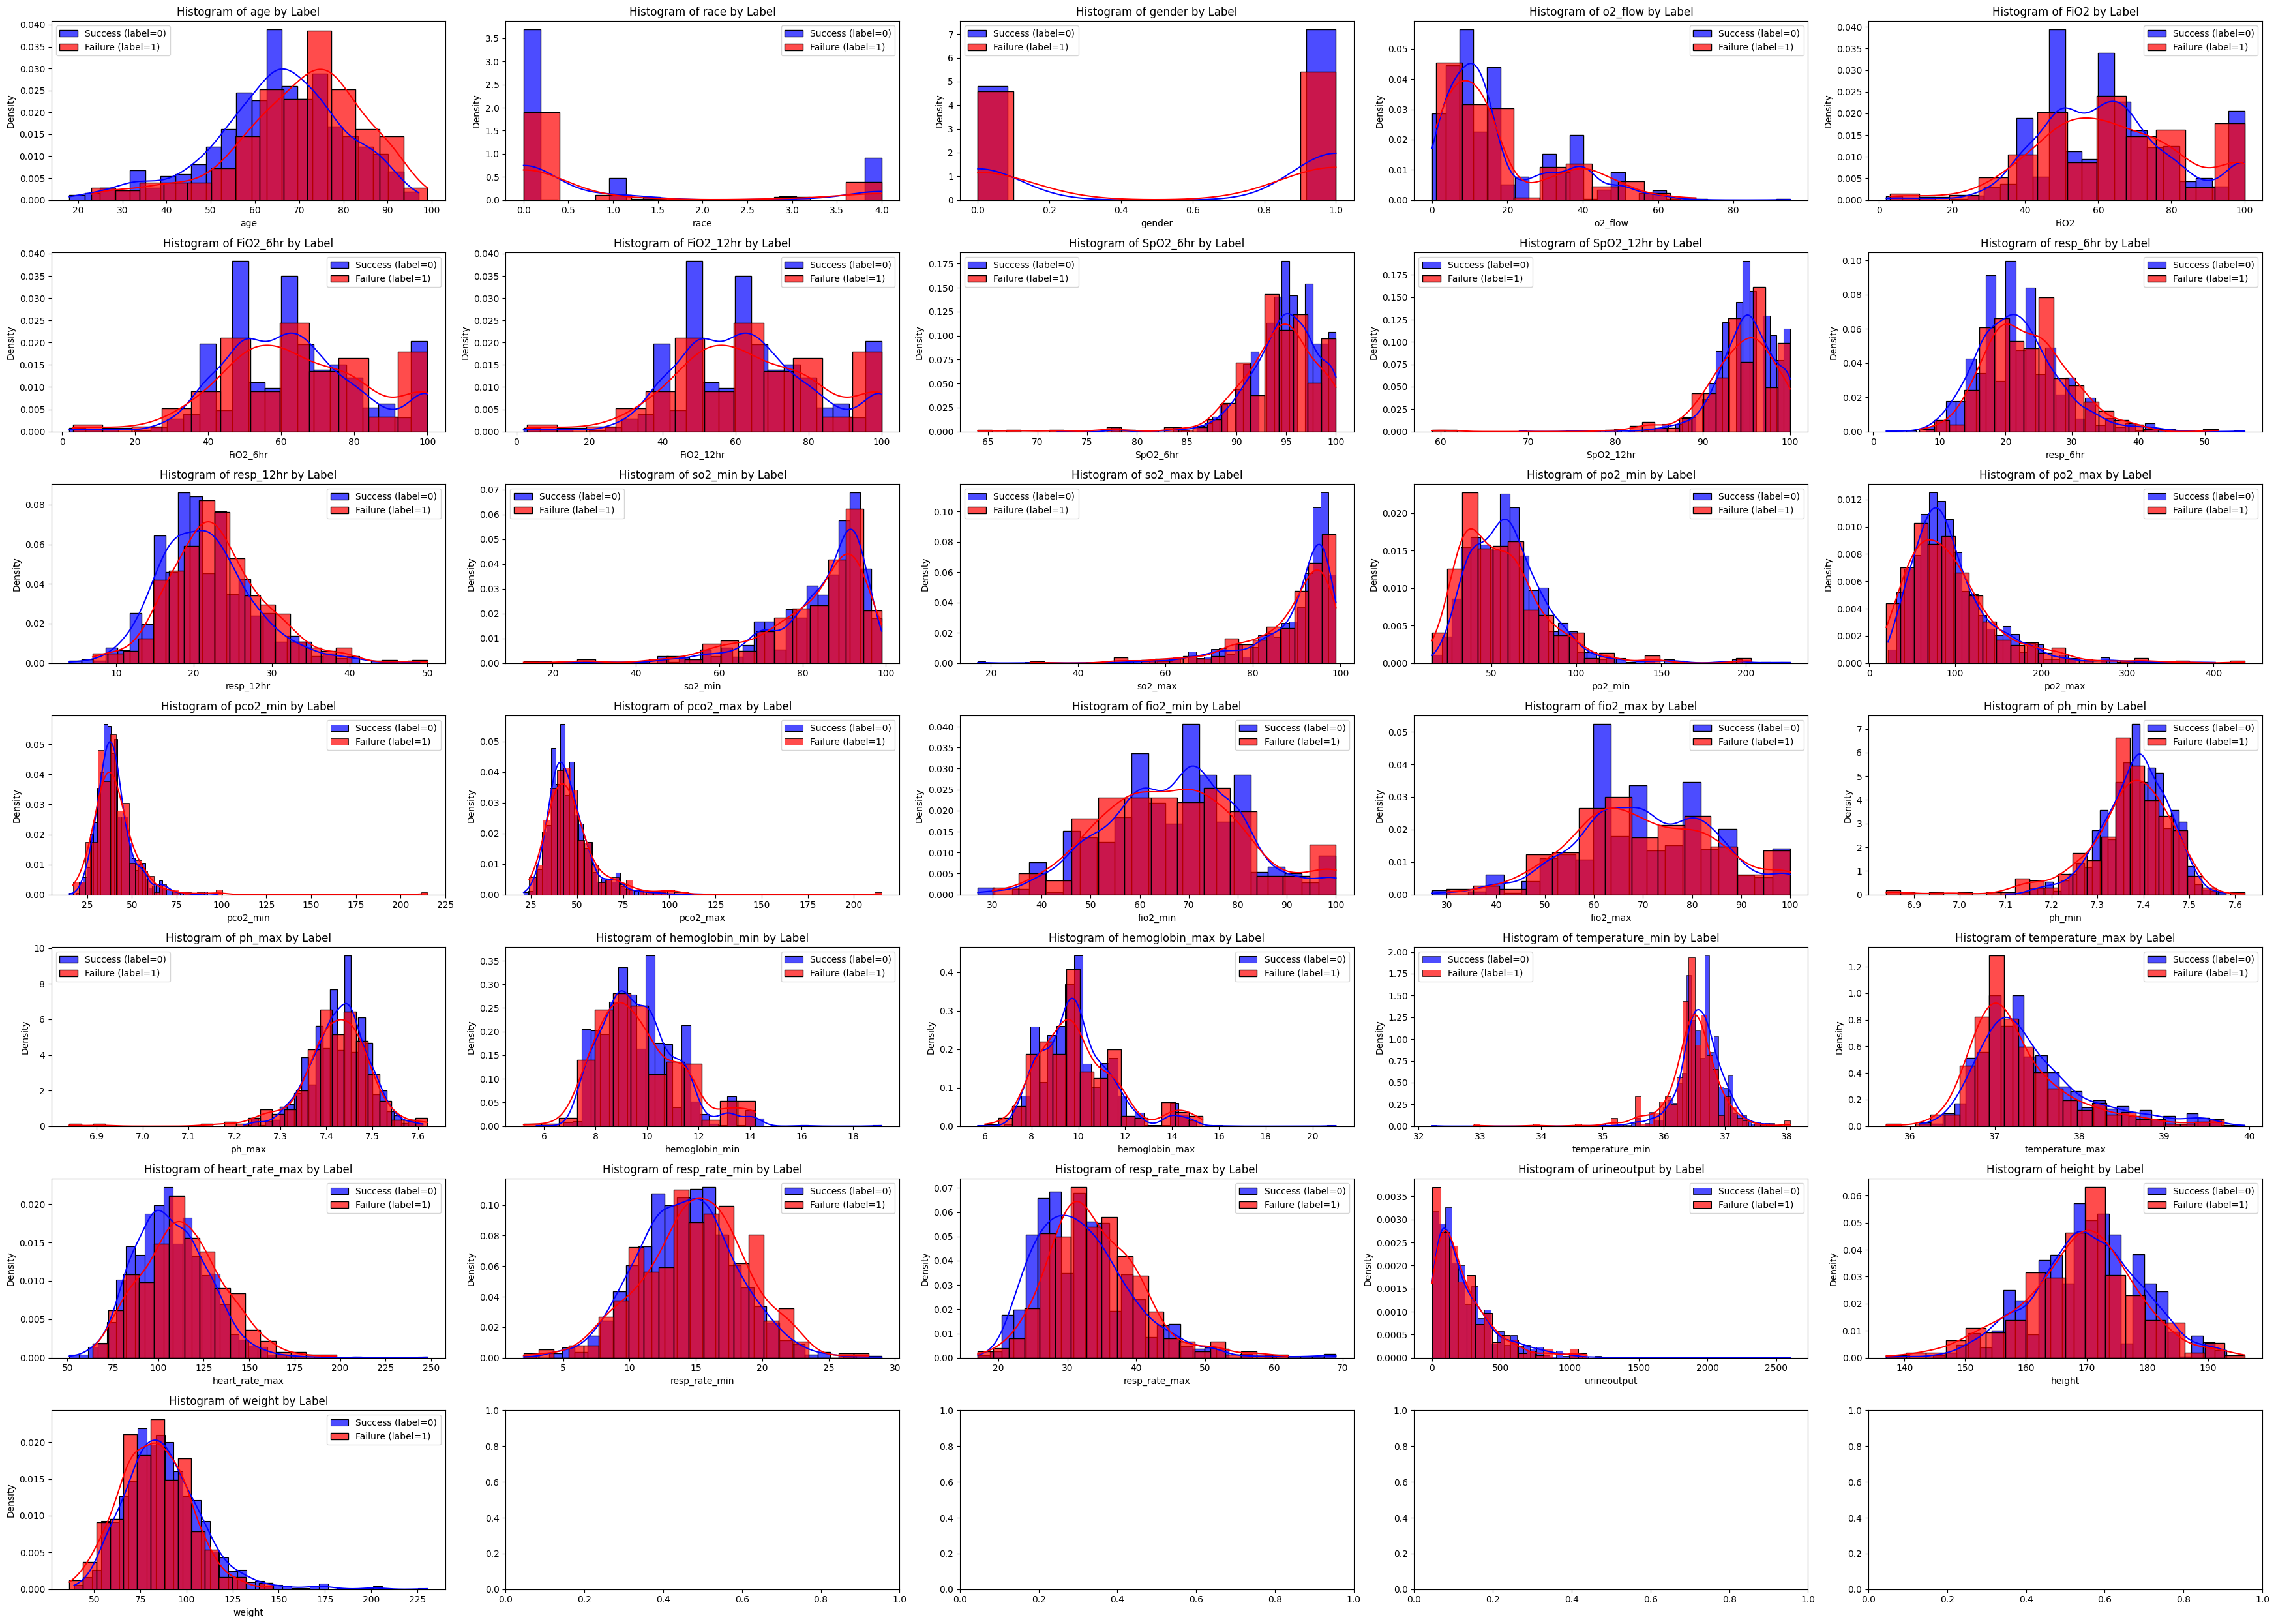

In [14]:
# observe the feature distribution after imputing missing value (knn (n =3))
columns_to_visualize = ['age', 'race', 'gender','o2_flow','FiO2','FiO2_6hr', 'FiO2_12hr','SpO2_6hr','SpO2_12hr','resp_6hr','resp_12hr','so2_min','so2_max','po2_min','po2_max','pco2_min','pco2_max','fio2_min','fio2_max','ph_min','ph_max','hemoglobin_min','hemoglobin_max','temperature_min','temperature_max','heart_rate_max','resp_rate_min','resp_rate_max','urineoutput','height','weight']

fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(35, 25))

axes = axes.flatten()

for i, column in enumerate(columns_to_visualize):
    data_success = df_knn[df_knn['label'] == 0][column].to_numpy()
    data_fail = df_knn[df_knn['label'] == 1][column].to_numpy()
    sns.histplot(data_success, color='blue', alpha=0.7, label='Success (label=0)', kde=True, ax=axes[i], stat='density', common_norm=False)
    sns.histplot(data_fail, color='red', alpha=0.7, label='Failure (label=1)', kde=True, ax=axes[i], stat='density', common_norm=False)

    axes[i].set_title(f'Histogram of {column} by Label')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.tight_layout()
plt.show()

## Outlier

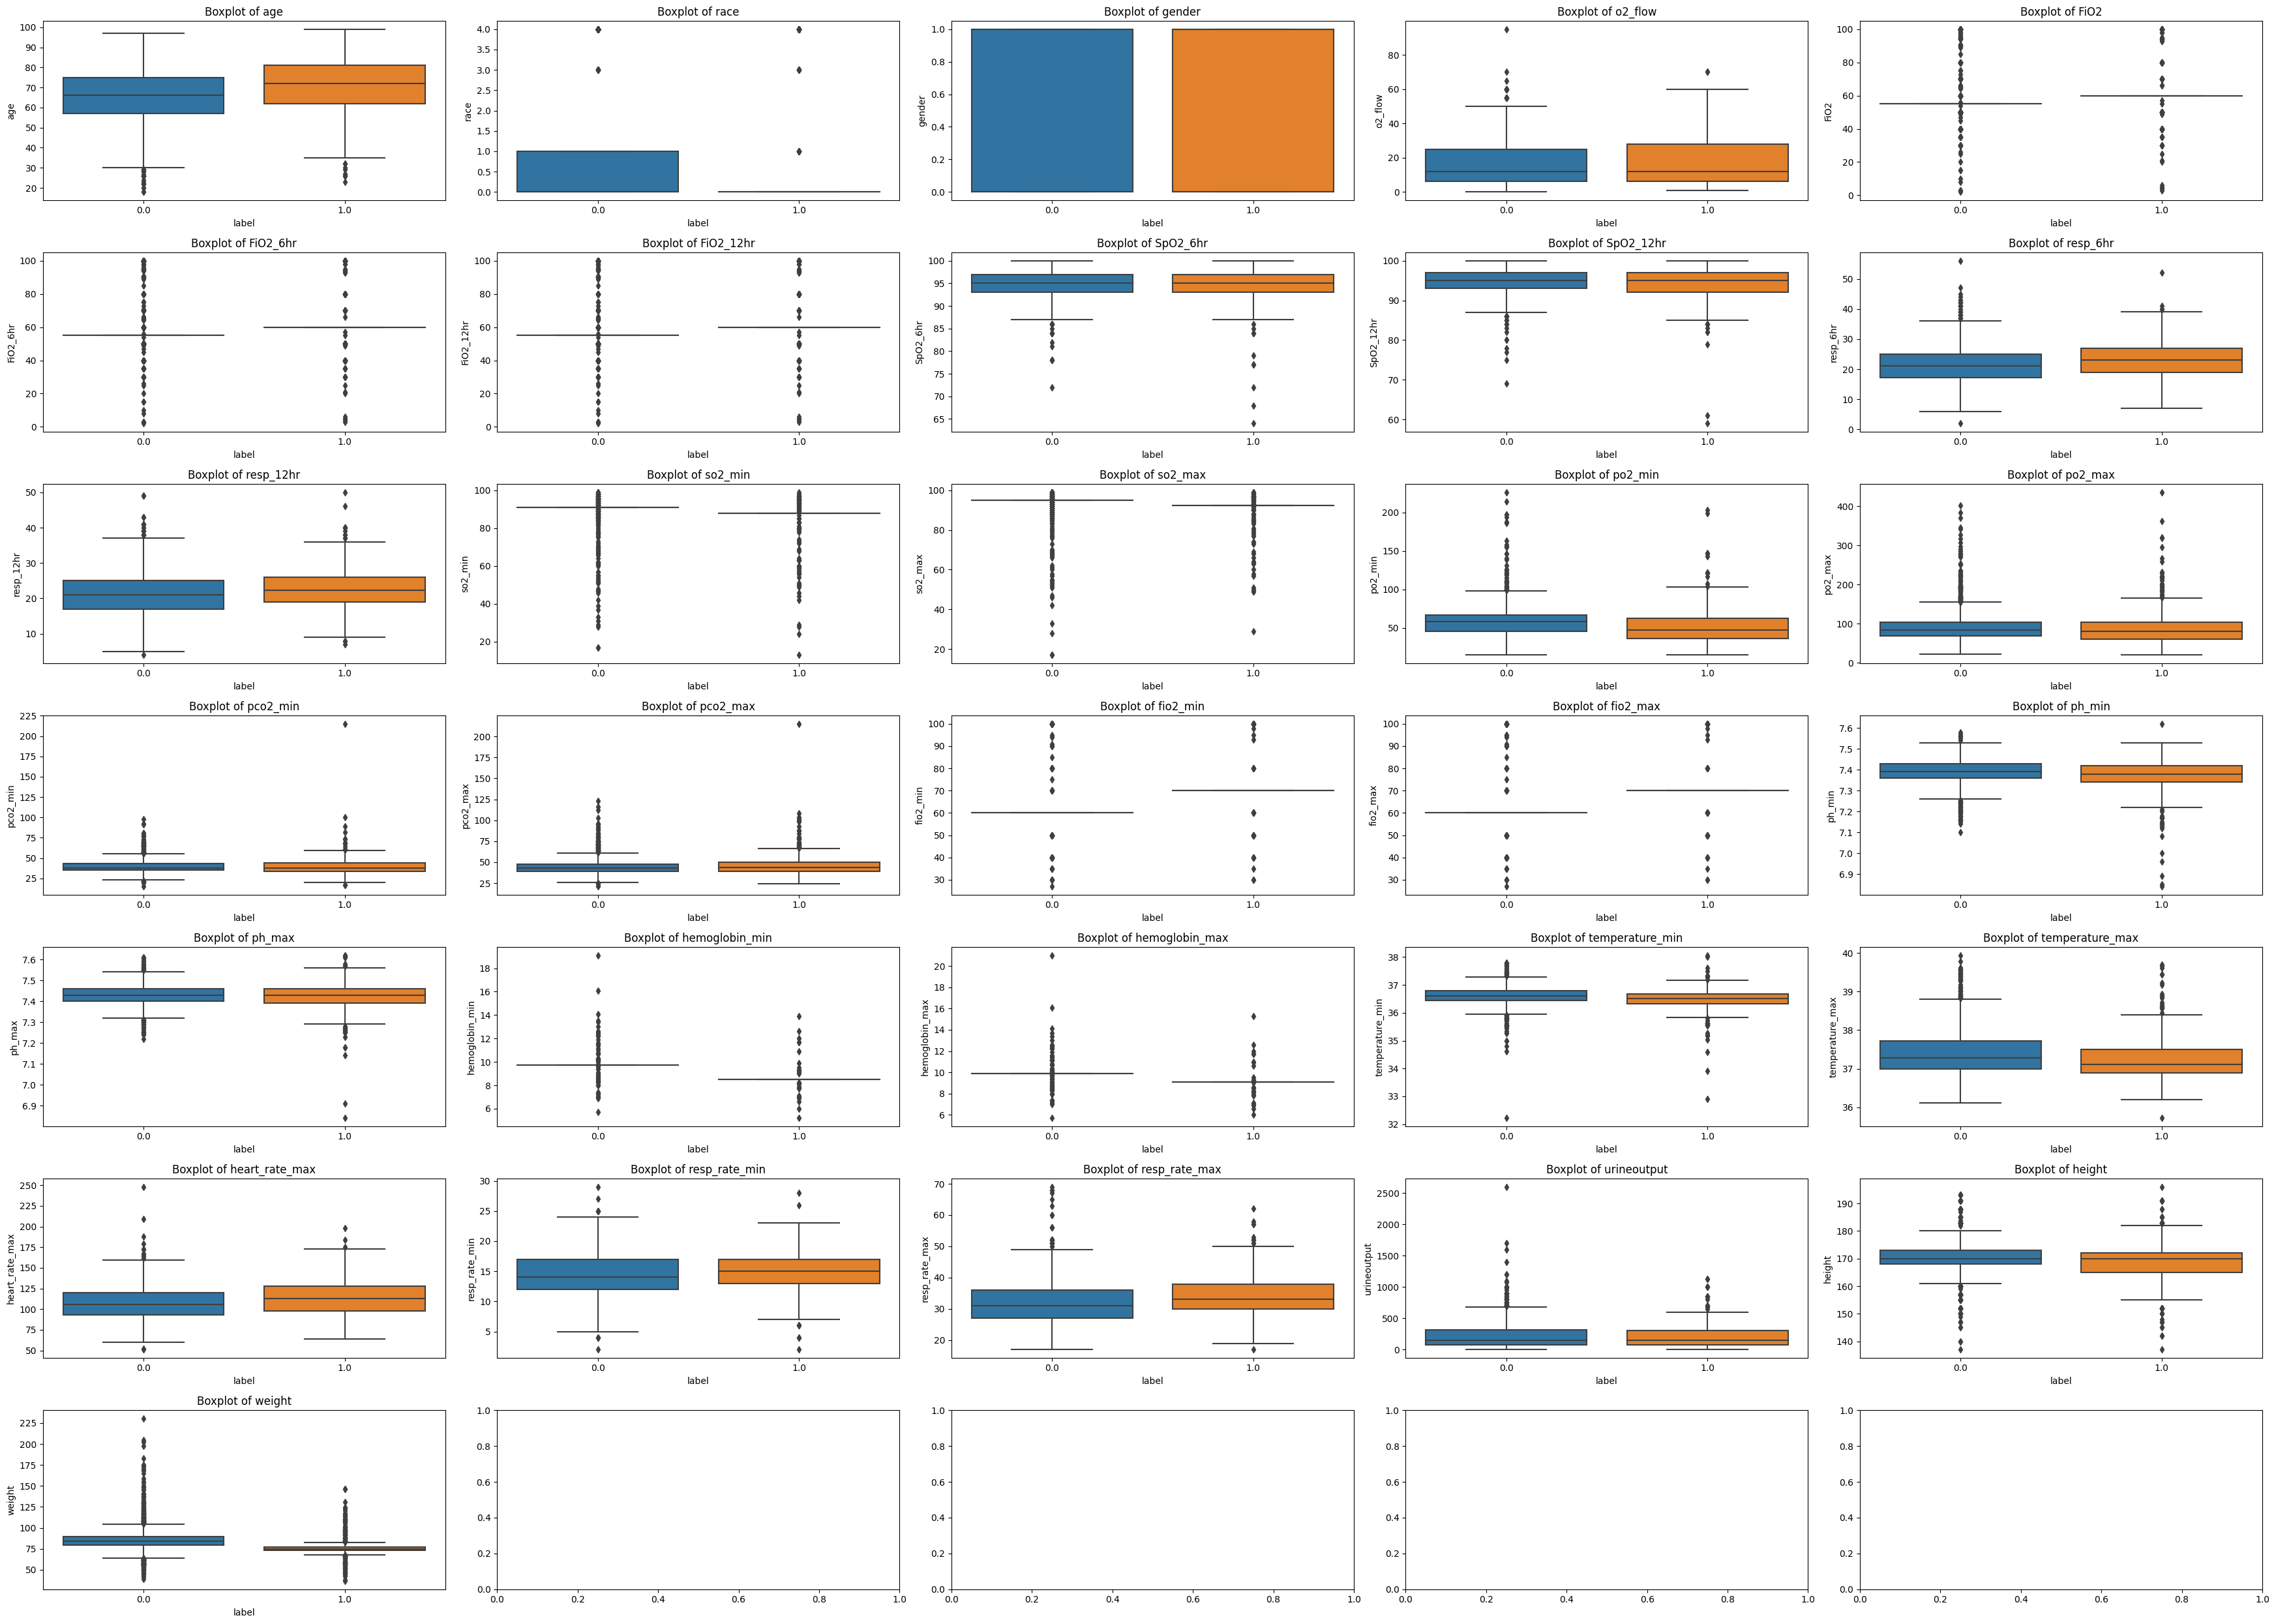

In [15]:
# df_median
# 要繪製的特徵列表
columns_to_visualize =  ['age', 'race', 'gender','o2_flow','FiO2','FiO2_6hr', 'FiO2_12hr','SpO2_6hr','SpO2_12hr','resp_6hr','resp_12hr','so2_min','so2_max','po2_min','po2_max','pco2_min','pco2_max','fio2_min','fio2_max','ph_min','ph_max','hemoglobin_min','hemoglobin_max','temperature_min','temperature_max','heart_rate_max','resp_rate_min','resp_rate_max','urineoutput','height','weight']

# 設定子圖的大小和排列
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(35, 25))

# 將每個特徵的盒狀圖繪製到子圖中
for i, column in enumerate(columns_to_visualize):
    row, col = divmod(i, 5)
    ax = axes[row, col]

    # 使用Seaborn的boxplot繪製盒狀圖
    sns.boxplot(x='label', y=column, data=df_median, ax=ax)

    # 設置子圖的標題
    ax.set_title(f'Boxplot of {column}')

# 調整子圖的排列
plt.tight_layout()

# 顯示圖形
plt.show()

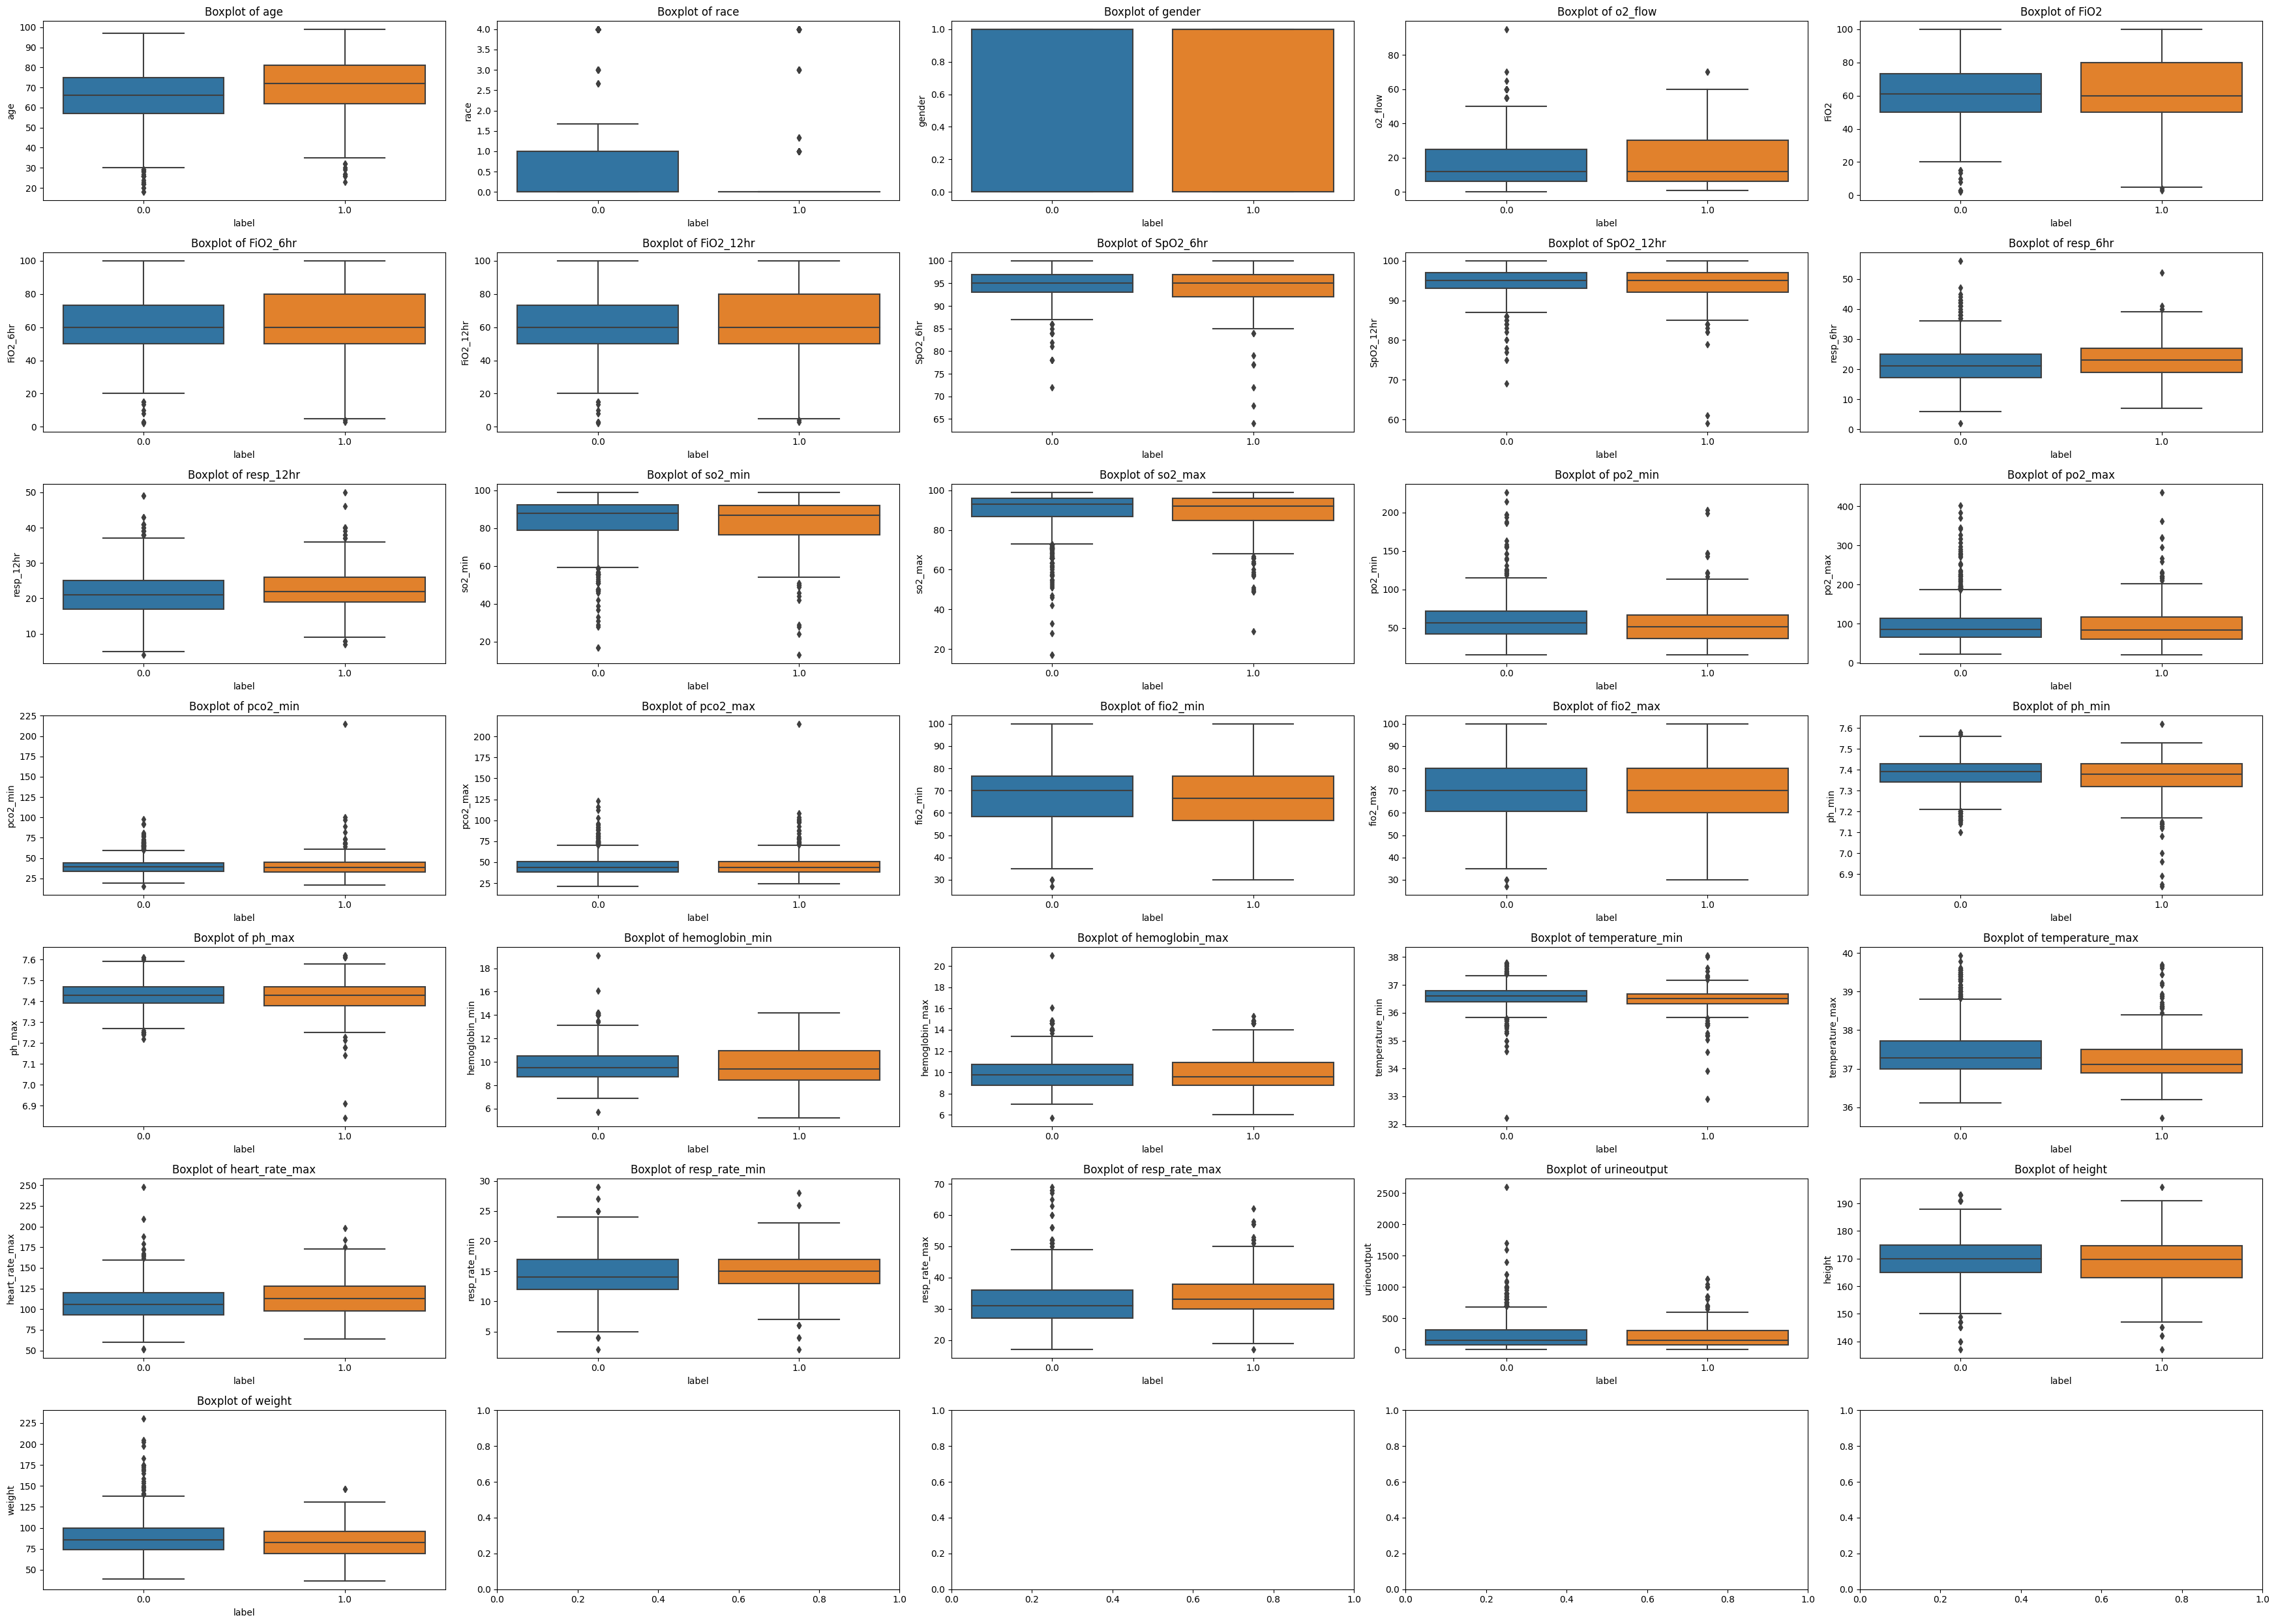

In [16]:
# df_median
# 要繪製的特徵列表
columns_to_visualize =  ['age', 'race', 'gender','o2_flow','FiO2','FiO2_6hr', 'FiO2_12hr','SpO2_6hr','SpO2_12hr','resp_6hr','resp_12hr','so2_min','so2_max','po2_min','po2_max','pco2_min','pco2_max','fio2_min','fio2_max','ph_min','ph_max','hemoglobin_min','hemoglobin_max','temperature_min','temperature_max','heart_rate_max','resp_rate_min','resp_rate_max','urineoutput','height','weight']

# 設定子圖的大小和排列
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(35, 25))

# 將每個特徵的盒狀圖繪製到子圖中
for i, column in enumerate(columns_to_visualize):
    row, col = divmod(i, 5)
    ax = axes[row, col]

    # 使用Seaborn的boxplot繪製盒狀圖
    sns.boxplot(x='label', y=column, data=df_knn, ax=ax)

    # 設置子圖的標題
    ax.set_title(f'Boxplot of {column}')

# 調整子圖的排列
plt.tight_layout()

# 顯示圖形
plt.show()

In [17]:
# 針對部分features進行outlier detection
features_to_detect_outliers =  ['o2_flow','FiO2','FiO2_6hr', 'FiO2_12hr','SpO2_6hr','SpO2_12hr','resp_6hr','resp_12hr','so2_min','so2_max','po2_min','po2_max','pco2_min','pco2_max','fio2_min','fio2_max','ph_min','ph_max','hemoglobin_min','hemoglobin_max','temperature_min','temperature_max','heart_rate_max','resp_rate_min','resp_rate_max','urineoutput']


# 創建 Isolation Forest 模型
model = IsolationForest(contamination=0.05)  # contamination 可以調整，表示異常值的期望比例

# 訓練模型
model.fit(df_median[features_to_detect_outliers])

# 預測異常值
predictions = model.predict(df_median[features_to_detect_outliers])

# 在原始數據中標識異常值
df_median['is_outlier'] = (predictions == -1)

# 計算異常值的數量
num_outliers = df_median['is_outlier'].sum()
print(f"總共有 {num_outliers} 筆異常值。")
print("異常值的索引值：")
print(df_median[df_median['is_outlier']].index)
df_median[features_to_detect_outliers] = df_median[features_to_detect_outliers].astype(float)
# 可以進一步查看標識的異常值
outliers = df_median[df_median['is_outlier']]

# 繪製散點矩陣
# Set the figure size
#plt.figure(figsize=(40, 40))  # Adjust the numbers (width, height) as needed
#sns.pairplot(df_median, hue='is_outlier', vars=features_to_detect_outliers)
#plt.show()

總共有 71 筆異常值。
異常值的索引值：
Int64Index([  21,   24,   25,   29,   46,   99,  100,  101,  124,  134,  157,
             187,  215,  222,  249,  280,  282,  299,  300,  319,  335,  349,
             354,  393,  430,  435,  538,  549,  575,  584,  612,  744,  758,
             795,  799,  824,  864,  892,  926,  935,  945,  956,  958,  991,
            1027, 1048, 1074, 1091, 1096, 1124, 1152, 1153, 1164, 1167, 1171,
            1208, 1228, 1236, 1253, 1263, 1271, 1278, 1291, 1301, 1310, 1333,
            1344, 1362, 1383, 1384, 1387],
           dtype='int64')


In [18]:
# 針對部分features進行outlier detection
features_to_detect_outliers =  ['o2_flow','FiO2','FiO2_6hr', 'FiO2_12hr','SpO2_6hr','SpO2_12hr','resp_6hr','resp_12hr','so2_min','so2_max','po2_min','po2_max','pco2_min','pco2_max','fio2_min','fio2_max','ph_min','ph_max','hemoglobin_min','hemoglobin_max','temperature_min','temperature_max','heart_rate_max','resp_rate_min','resp_rate_max','urineoutput']


# 創建 Isolation Forest 模型
model = IsolationForest(contamination=0.05)  # contamination 可以調整，表示異常值的期望比例

# 訓練模型
model.fit(df_knn[features_to_detect_outliers])

# 預測異常值
predictions = model.predict(df_knn[features_to_detect_outliers])

# 在原始數據中標識異常值
df_knn['is_outlier'] = (predictions == -1)

# 計算異常值的數量
num_outliers = df_knn['is_outlier'].sum()
print(f"總共有 {num_outliers} 筆異常值。")
print("異常值的索引值：")
print(df_knn[df_knn['is_outlier']].index)
df_knn[features_to_detect_outliers] = df_knn[features_to_detect_outliers].astype(float)
# 可以進一步查看標識的異常值
outliers = df_knn[df_knn['is_outlier']]

# 繪製散點矩陣
# Set the figure size
#plt.figure(figsize=(40, 40))  # Adjust the numbers (width, height) as needed
#sns.pairplot(df_knn, hue='is_outlier', vars=features_to_detect_outliers)
#plt.show()

總共有 71 筆異常值。
異常值的索引值：
Int64Index([  21,   24,   46,   52,   99,  100,  101,  119,  148,  187,  215,
             222,  249,  282,  287,  319,  335,  349,  383,  394,  414,  421,
             435,  538,  549,  567,  575,  605,  612,  616,  658,  668,  716,
             752,  757,  765,  795,  799,  824,  870,  892,  926,  958,  966,
             971,  994,  997, 1027, 1040, 1048, 1074, 1096, 1114, 1124, 1167,
            1171, 1179, 1198, 1247, 1271, 1273, 1283, 1291, 1310, 1314, 1325,
            1333, 1370, 1384, 1387, 1405],
           dtype='int64')


In [19]:
df_median.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407 entries, 0 to 1406
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stay_id          1407 non-null   int64  
 1   age              1407 non-null   int64  
 2   race             1407 non-null   float64
 3   gender           1407 non-null   int64  
 4   FiO2             1407 non-null   float64
 5   o2_flow          1407 non-null   float64
 6   FiO2_6hr         1407 non-null   float64
 7   FiO2_12hr        1407 non-null   float64
 8   SpO2_6hr         1407 non-null   float64
 9   SpO2_12hr        1407 non-null   float64
 10  resp_6hr         1407 non-null   float64
 11  resp_12hr        1407 non-null   float64
 12  label            1407 non-null   float64
 13  so2_min          1407 non-null   float64
 14  so2_max          1407 non-null   float64
 15  po2_min          1407 non-null   float64
 16  po2_max          1407 non-null   float64
 17  pco2_min      

In [20]:
imputer = KNNImputer(n_neighbors=5)
identified_outliers = df_median[df_median['is_outlier']].index

for outlier_index in identified_outliers:
    # Select the outlier row and features to impute
    outlier_data = df_median.loc[outlier_index, features_to_detect_outliers].values.reshape(1, -1)

    # Apply imputation to the outlier features and update the DataFrame
    imputed_values = imputer.fit_transform(outlier_data)
    df_median.loc[outlier_index, features_to_detect_outliers] = imputed_values.flatten()
df_median = df_median.drop(['is_outlier'], axis = 1)

In [21]:
imputer = KNNImputer(n_neighbors=5)
identified_outliers = df_knn[df_knn['is_outlier']].index

for outlier_index in identified_outliers:
    # Select the outlier row and features to impute
    outlier_data = df_knn.loc[outlier_index, features_to_detect_outliers].values.reshape(1, -1)

    # Apply imputation to the outlier features and update the DataFrame
    imputed_values = imputer.fit_transform(outlier_data)
    df_knn.loc[outlier_index, features_to_detect_outliers] = imputed_values.flatten()
df_knn = df_knn.drop(['is_outlier'], axis = 1)

In [22]:
# compute ROX_6hr, ROX_12hr
ROX_6hr = []
ROX_12hr = []
for i in range (0, df_median.shape[0]):
   ROX_6hr.append((df_median['SpO2_6hr'][i]/df_median['FiO2_6hr'][i])/df_median['resp_6hr'][i])
   ROX_12hr.append((df_median['SpO2_12hr'][i]/df_median['FiO2_12hr'][i])/df_median['resp_12hr'][i])
df_median.insert(31, "ROX_6hr", ROX_6hr, True)
df_median.insert(32, "ROX_12hr", ROX_12hr, True)

In [23]:
# compute ROX_6hr, ROX_12hr
ROX_6hr = []
ROX_12hr = []
for i in range (0, df_knn.shape[0]):
   ROX_6hr.append((df_knn['SpO2_6hr'][i]/df_knn['FiO2_6hr'][i])/df_knn['resp_6hr'][i])
   ROX_12hr.append((df_knn['SpO2_12hr'][i]/df_knn['FiO2_12hr'][i])/df_knn['resp_12hr'][i])
df_knn.insert(31, "ROX_6hr", ROX_6hr, True)
df_knn.insert(32, "ROX_12hr", ROX_12hr, True)

In [24]:
df_median.head()

stay_id  age  race  gender  FiO2  o2_flow  FiO2_6hr  FiO2_12hr  SpO2_6hr  \
0  39469161   20   0.0       1  55.0      5.0      55.0       55.0      97.0   
1  33580370   32   0.0       0  55.0     30.0      55.0       55.0      95.0   
2  38975964   26   4.0       1  60.0      4.0      60.0       60.0      92.0   
3  34691729   28   0.0       0  55.0     20.0      55.0       55.0     100.0   
4  36158255   29   4.0       1  60.0     10.0      60.0       60.0      98.0   

   SpO2_12hr  ...  temperature_min  temperature_max  heart_rate_max  \
0       93.0  ...            36.67            37.67           112.0   
1       95.0  ...            36.83            37.78           144.0   
2       94.0  ...            37.06            37.56           145.0   
3       98.0  ...            36.50            37.28           119.0   
4       96.0  ...            37.33            38.39            78.0   

   resp_rate_min  resp_rate_max  urineoutput   ROX_6hr  ROX_12hr  height  \
0           12.0           27.0        300.0  0.097980  0.093939   191.0   
1           20.0           34.0        350.0  0.069091  0.057576   170.0   
2           13.0           49.0        125.0  0.032624  0.031973   150.0   
3           16.0           67.0        110.0  0.106952  0.104813   170.0   
4           12.0           24.0        220.0  0.081667  0.123077   173.0   

   weight  
0   120.6  
1    83.8  
2    83.8  
3   112.6  
4    66.8  

[5 rows x 35 columns]

In [25]:
df_knn.head()

stay_id   age  race  gender       FiO2  o2_flow   FiO2_6hr  FiO2_12hr  \
0  39469161.0  20.0   0.0     1.0  60.000000      5.0  60.000000  60.000000   
1  33580370.0  32.0   0.0     0.0  66.666667     30.0  73.333333  73.333333   
2  38975964.0  26.0   4.0     1.0  60.000000      4.0  60.000000  60.000000   
3  34691729.0  28.0   0.0     0.0  58.333333     20.0  58.333333  58.333333   
4  36158255.0  29.0   4.0     1.0  80.000000     10.0  86.666667  86.666667   

   SpO2_6hr  SpO2_12hr  ...  temperature_min  temperature_max  heart_rate_max  \
0      97.0       93.0  ...            36.67            37.67           112.0   
1      95.0       95.0  ...            36.83            37.78           144.0   
2      92.0       94.0  ...            37.06            37.56           145.0   
3     100.0       98.0  ...            36.50            37.28           119.0   
4      98.0       96.0  ...            37.33            38.39            78.0   

   resp_rate_min  resp_rate_max  urineoutput   ROX_6hr  ROX_12hr      height  \
0           12.0           27.0        300.0  0.089815  0.086111  191.000000   
1           20.0           34.0        350.0  0.051818  0.043182  168.666667   
2           13.0           49.0        125.0  0.032624  0.031973  150.000000   
3           16.0           67.0        110.0  0.100840  0.098824  164.000000   
4           12.0           24.0        220.0  0.056538  0.085207  173.000000   

       weight  
0  120.600000  
1  104.266667  
2   66.800000  
3  112.600000  
4   66.800000  

[5 rows x 35 columns]

In [26]:
df_median.to_csv('HFNC_median.csv')
df_knn.to_csv('HFNC_knn.csv')

In [27]:
#label = 1 means HFNC failure
columns = ['age', 'race', 'gender','o2_flow','FiO2','FiO2_6hr', 'FiO2_12hr','SpO2_6hr','SpO2_12hr','resp_6hr','resp_12hr','label','so2_min','so2_max','po2_min','po2_max','pco2_min','pco2_max','fio2_min','fio2_max','ph_min','ph_max','hemoglobin_min','hemoglobin_max','temperature_min','temperature_max','heart_rate_max','resp_rate_min','resp_rate_max','urineoutput','height','weight','ROX_6hr','ROX_12hr']
groupby = 'label'
table1 = TableOne(df_median, groupby = groupby, columns = columns, pval = True)
display(table1)

Grouped by label                                                     
                                        Missing        Overall            0.0            1.0 P-Value
n                                                         1407           1078            329        
age, mean (SD)                                0    66.3 (14.9)    65.1 (14.7)    70.3 (14.6)  <0.001
race, n (%)                0.0                0    1033 (73.4)     777 (72.1)     256 (77.8)   0.005
                           1.0                       109 (7.7)       97 (9.0)       12 (3.6)        
                           3.0                        25 (1.8)       16 (1.5)        9 (2.7)        
                           4.0                      240 (17.1)     188 (17.4)      52 (15.8)        
gender, n (%)              0                  0     583 (41.4)     432 (40.1)     151 (45.9)   0.070
                           1                        824 (58.6)     646 (59.9)     178 (54.1)        
o2_flow, mean (SD)                            0    17.1 (14.8)    17.0 (14.6)    17.3 (15.5)   0.754
FiO2, mean (SD)                               0    59.3 (16.8)    58.3 (16.1)    62.5 (18.7)  <0.001
FiO2_6hr, mean (SD)                           0    59.2 (16.9)    58.2 (16.1)    62.7 (18.8)  <0.001
FiO2_12hr, mean (SD)                          0    59.2 (16.9)    58.2 (16.1)    62.7 (18.8)  <0.001
SpO2_6hr, mean (SD)                           0     94.8 (3.7)     94.9 (3.4)     94.3 (4.4)   0.016
SpO2_12hr, mean (SD)                          0     94.8 (3.8)     95.0 (3.4)     94.3 (4.6)   0.017
resp_6hr, mean (SD)                           0     22.2 (6.3)     21.8 (6.3)     23.3 (6.2)  <0.001
resp_12hr, mean (SD)                          0     21.9 (6.2)     21.5 (6.1)     23.0 (6.3)  <0.001
so2_min, mean (SD)                            0     88.5 (9.3)     89.5 (8.4)    85.4 (11.1)  <0.001
so2_max, mean (SD)                            0     93.0 (7.6)     93.7 (7.2)     90.7 (8.3)  <0.001
po2_min, mean (SD)                            0    58.1 (23.9)    59.7 (23.4)    52.7 (25.0)  <0.001
po2_max, mean (SD)                            0    93.2 (49.5)    93.2 (47.7)    92.9 (55.2)   0.917
pco2_min, mean (SD)                           0    39.8 (10.9)     39.7 (9.6)    40.2 (14.3)   0.606
pco2_max, mean (SD)                           0    45.7 (12.9)    45.2 (11.6)    47.2 (16.3)   0.036
fio2_min, mean (SD)                           0     62.8 (9.8)     60.6 (8.6)    70.1 (10.1)  <0.001
fio2_max, mean (SD)                           0    63.3 (10.3)     61.1 (9.3)    70.4 (10.1)  <0.001
ph_min, mean (SD)                             0      7.4 (0.1)      7.4 (0.1)      7.4 (0.1)  <0.001
ph_max, mean (SD)                             0      7.4 (0.1)      7.4 (0.1)      7.4 (0.1)   0.037
hemoglobin_min, mean (SD)                     0      9.4 (0.8)      9.7 (0.6)      8.5 (0.6)  <0.001
hemoglobin_max, mean (SD)                     0      9.7 (0.7)      9.9 (0.6)      9.1 (0.6)  <0.001
temperature_min, mean (SD)                    0     36.6 (0.4)     36.6 (0.4)     36.5 (0.5)  <0.001
temperature_max, mean (SD)                    0     37.4 (0.7)     37.4 (0.7)     37.3 (0.6)  <0.001
heart_rate_max, mean (SD)                     0   108.6 (21.2)   107.1 (20.6)   113.6 (22.4)  <0.001
resp_rate_min, mean (SD)                      0     14.5 (3.8)     14.3 (3.7)     15.0 (3.9)   0.004
resp_rate_max, mean (SD)                      0     32.7 (7.2)     32.3 (7.3)     34.0 (6.8)  <0.001
urineoutput, mean (SD)                        0  231.6 (228.6)  235.5 (235.5)  218.9 (204.2)   0.215
height, mean (SD)                             0    169.8 (8.3)    170.1 (8.1)    168.9 (8.8)   0.026
weight, mean (SD)                             0    84.1 (19.4)    86.3 (20.0)    76.6 (15.4)  <0.001
ROX_6hr, mean (SD)                            0      0.1 (0.1)      0.1 (0.2)      0.1 (0.1)   0.321
ROX_12hr, mean (SD)                           0      0.1 (0.1)      0.1 (0.1)      0.1 (0.1)

In [28]:
#label = 1 means HFNC failure
columns = ['age', 'race', 'gender','o2_flow','FiO2','FiO2_6hr', 'FiO2_12hr','SpO2_6hr','SpO2_12hr','resp_6hr','resp_12hr','label','so2_min','so2_max','po2_min','po2_max','pco2_min','pco2_max','fio2_min','fio2_max','ph_min','ph_max','hemoglobin_min','hemoglobin_max','temperature_min','temperature_max','heart_rate_max','resp_rate_min','resp_rate_max','urineoutput','height','weight','ROX_6hr','ROX_12hr']
groupby = 'label'
table1 = TableOne(df_knn, groupby = groupby, columns = columns, pval = True)
display(table1)

Grouped by label                                                     
                                        Missing        Overall            0.0            1.0 P-Value
n                                                         1407           1078            329        
age, mean (SD)                                0    66.3 (14.9)    65.1 (14.7)    70.3 (14.6)  <0.001
race, mean (SD)                               0      0.8 (1.5)      0.9 (1.5)      0.8 (1.5)   0.351
gender, n (%)              0.0                0     583 (41.4)     432 (40.1)     151 (45.9)   0.070
                           1.0                      824 (58.6)     646 (59.9)     178 (54.1)        
o2_flow, mean (SD)                            0    17.2 (14.8)    17.1 (14.6)    17.4 (15.6)   0.785
FiO2, mean (SD)                               0    63.2 (19.1)    62.9 (18.5)    64.2 (20.9)   0.328
FiO2_6hr, mean (SD)                           0    63.4 (19.2)    63.1 (18.7)    64.5 (21.0)   0.284
FiO2_12hr, mean (SD)                          0    63.4 (19.2)    63.1 (18.7)    64.5 (21.0)   0.284
SpO2_6hr, mean (SD)                           0     94.8 (3.7)     94.9 (3.4)     94.2 (4.5)   0.012
SpO2_12hr, mean (SD)                          0     94.8 (3.8)     95.0 (3.4)     94.3 (4.6)   0.014
resp_6hr, mean (SD)                           0     22.2 (6.3)     21.8 (6.3)     23.3 (6.2)  <0.001
resp_12hr, mean (SD)                          0     21.9 (6.2)     21.5 (6.1)     23.0 (6.3)  <0.001
so2_min, mean (SD)                            0    83.8 (12.1)    84.1 (11.7)    82.7 (13.4)   0.077
so2_max, mean (SD)                            0    89.3 (10.1)    89.6 (10.0)    88.5 (10.5)   0.087
po2_min, mean (SD)                            0    59.0 (24.9)    60.1 (24.5)    55.5 (25.9)   0.005
po2_max, mean (SD)                            0    96.0 (51.1)    96.0 (49.4)    96.2 (56.2)   0.934
pco2_min, mean (SD)                           0    40.2 (11.3)    40.1 (10.0)    40.6 (14.8)   0.637
pco2_max, mean (SD)                           0    46.3 (13.3)    46.0 (12.1)    47.5 (16.8)   0.109
fio2_min, mean (SD)                           0    67.2 (14.0)    67.2 (13.7)    67.2 (14.9)   0.990
fio2_max, mean (SD)                           0    70.8 (14.3)    70.8 (14.2)    70.6 (14.8)   0.825
ph_min, mean (SD)                             0      7.4 (0.1)      7.4 (0.1)      7.4 (0.1)   0.003
ph_max, mean (SD)                             0      7.4 (0.1)      7.4 (0.1)      7.4 (0.1)   0.046
hemoglobin_min, mean (SD)                     0      9.7 (1.5)      9.7 (1.5)      9.7 (1.7)   0.689
hemoglobin_max, mean (SD)                     0      9.9 (1.6)      9.9 (1.5)     10.0 (1.7)   0.396
temperature_min, mean (SD)                    0     36.6 (0.4)     36.6 (0.4)     36.5 (0.5)  <0.001
temperature_max, mean (SD)                    0     37.4 (0.7)     37.4 (0.7)     37.3 (0.6)  <0.001
heart_rate_max, mean (SD)                     0   108.6 (21.2)   107.1 (20.6)   113.6 (22.4)  <0.001
resp_rate_min, mean (SD)                      0     14.5 (3.8)     14.3 (3.7)     15.0 (3.9)   0.004
resp_rate_max, mean (SD)                      0     32.7 (7.2)     32.3 (7.3)     34.0 (6.8)  <0.001
urineoutput, mean (SD)                        0  233.1 (229.7)  235.9 (235.5)  223.7 (209.6)   0.369
height, mean (SD)                             0    169.7 (9.1)    170.0 (8.9)    168.8 (9.5)   0.036
weight, mean (SD)                             0    86.5 (21.4)    87.7 (22.0)    82.5 (18.6)  <0.001
ROX_6hr, mean (SD)                            0      0.1 (0.1)      0.1 (0.2)      0.1 (0.1)   0.705
ROX_12hr, mean (SD)                           0      0.1 (0.1)      0.1 (0.1)      0.1 (0.1)   0.691